In [2]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection, linear_model
from sklearn import mixture
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from nilearn import image, plotting
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
def PCA_LR_pipeline(in_mtx, y, pca = PCA(random_state=123), 
                    clf = linear_model.LassoCV(random_state = 123), 
                    cv_strategy = None, cv = 10, test_gene_num = [100], illustrative = False,
                   sanity_check_style = 'separate', cv_labels = [], reverse_axes = True):
    
    final_outputs = {}
    
    if type(in_mtx) == pandas.core.frame.DataFrame:
        in_mtx = in_mtx.values
    
    if type(pca) == type(None):
        pca_tfm = in_mtx
    else:
        print('running PCA')
        dat_pca = pca.fit(in_mtx)
        print('transforming data')
        pca_tfm = dat_pca.transform(in_mtx)
        #if len(y) != pca_tfm.shape[-1]:
        #    raise ValueError('length of y-axis of transformed item must match the length of y')
        final_outputs.update({'pca_object': dat_pca})
    
    
    print('performing model cross-validation')
    if hasattr(cv_strategy, 'get_n_splits'):
        folds = cv_strategy.get_n_splits(pca_tfm)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, groups=folds, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, groups=folds, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    elif cv_strategy == 'LOLO':
        print('using leave-one-label-out cross-validation')
        observed, predicted = leave_one_x_out(cv_labels, pca_tfm, y, clf)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif cv_strategy == 'balanced':
        print('balancing cross-validation by labels')
        observed, predicted = balanced_cv(cv_labels, pca_tfm, y, clf, cv)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif type(cv_strategy) == int:
        print('using %s iterations of %s-fold cross-validation'%(cv_strategy,cv))
        score = []
        preds = np.zeros((cv_strategy,len(y)))
        for i in range(cv_strategy):
            sel = model_selection.KFold(n_splits=cv, shuffle=True)
            predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=sel)
            preds[i,:] = predicted
            score.append(stats.pearsonr(predicted, y)[0]**2)
            print('completed iteration',i+1)
    elif type(cv_strategy) != type(None):
        print('using basic %s-fold cross-validation'%cv)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=cv)
        observed = y
        try:
            score = stats.pearsonr(predicted, y)[0]**2
        except:
            score = stats.pearsonr(predicted[:,0], y)[0]**2
    else:
        score = None
    if type(score) != type(None):
        if type(score) == list:
            if illustrative:
                plt.close()
                sns.regplot(preds.mean(0), y, fit_reg=False)
                plt.xlabel('Average CV model predicted position along axis')
                plt.ylabel('Actual position along axis')
                plt.show()

                jnk = pandas.DataFrame(index = range(cv_strategy+1), 
                                       columns = ['score','iteration'])
                jnk.loc[:,'iteration'] = list(range(cv_strategy)) + ['mean']
                jnk.loc[:,'score'] = score + [np.mean(score)]
                plt.close()
                sns.factorplot(x='iteration',y='score',data=jnk)
                plt.show()
                print('model cv scores (r2):')
                print(score)
                print('average r2:',np.mean(score))
                final_outputs.update({'CV_scores': score})
        else:        
            if illustrative:
                plt.close()
                sns.regplot(predicted, observed, fit_reg=False)
                plt.xlabel('CV model predicted position along axis')
                plt.ylabel('Actual position along axis')
                plt.show()
            print('model cv score: r2 = ',score)
            final_outputs.update({'CV_scores': score})
    else:
        print('no valid cross-validation method specified')
    
    print('running final model')
    mod = clf.fit(pca_tfm, y)
    if not hasattr(mod,'coef_'):
        raise IOError('right now, this pipeline can only accept clf objects with a coef_ attribute')
    final_outputs.update({'final_model': mod})
    scr = mod.score(pca_tfm, y)
    print('final model fit r2 = ',scr)
    if illustrative:
        plt.close()
        sns.regplot(x=mod.predict(pca_tfm), y=y)
        plt.xlabel('Model predicted position along A-P axis')
        plt.ylabel('Actual position along A-P axis')
        plt.show()
    
    if type(pca) == type(None):
        f_betas = mod.coef_
    else:
        f_betas = back_transform(dat_pca, mod)
    final_outputs.update({'betas': f_betas})
    
    gene_selections = sanity_check(in_mtx, y, f_betas, test_gene_num, 
                                   illustrative, sanity_check_style, reverse_axes)
    final_outputs.update({'gene_selections': gene_selections})
    
    return final_outputs
    
def back_transform(pca_obj, clf_obj):
    return np.dot(pca_obj.components_.T,clf_obj.coef_)

def sanity_check(in_mtx, y, betas, test_gene_num, illustrative, 
                 sanity_check_style, reverse_axes):
    
    if sanity_check_style == 'separate':
        ascores = []
        pscores = []
    else:
        scores = []
    print('running sanity_check')
    try:
        betas = pandas.Series(betas)
    except:
        betas = pandas.Series(betas[:,0])
    outputs = {}
    for num in test_gene_num:
      
        p_chk = betas.sort_values(ascending=False)[:num].index
        a_chk = betas.sort_values(ascending=False)[-num:].index

        pchk_vals = []
        achk_vals = []
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in p_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'model':
                pchk_vals.append(np.mean(np.array(to_avg) * betas.loc[p_chk].values))
            else:
                pchk_vals.append(np.mean(to_avg))
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in a_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'separate':
                achk_vals.append(np.mean(to_avg))
            elif sanity_check_style == 'model':
                achk_vals.append(np.mean(np.array(to_avg) * betas.loc[a_chk].values))
            else:
                achk_vals.append(np.mean(to_avg) * -1)

        if sanity_check_style != 'separate':
            chk_vals = np.array(pchk_vals) + np.array(achk_vals)
            
        if sanity_check_style == 'separate':
            pr,pp = stats.pearsonr(pchk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
                if reverse_axes:
                    plt.xlabel('expression of anterior direction genes')
                    plt.ylabel('location along hippocampus (anterior = higher)')
                    plt.show()
                    print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))
                else:
                    plt.xlabel('expression of posterior direction genes')
                    plt.ylabel('location along hippocampus (posterior = higher)')
                    plt.show()
                    print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

            ar,ap = stats.pearsonr(achk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
                if reverse_axes:
                    plt.xlabel('expression of posterior direction genes')
                    plt.ylabel('location along hippocampus (anterior = higher)')
                    plt.show()
                    print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
                else:
                    plt.xlabel('expression of anterior direction genes')
                    plt.ylabel('location along hippocampus (posterior = higher)')
                    plt.show()
                    print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            
        else:
            r,p = stats.pearsonr(chk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of A-P axis genes')
                if reverse_axes:
                    plt.ylabel('location along hippocampus (anterior = higher)')
                else:
                    plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
                print('posterior and anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(
                                                                                num, r**2, p))
            
        if sanity_check_style == 'separate':
            if reverse_axes:
                ascores.append(pr**2)
                pscores.append(ar**2)
            else:
                ascores.append(ar**2)
                pscores.append(pr**2)
        else:
            scores.append(r**2)
        if reverse_axes:
            outputs.update({'posterior_genes_%s'%num: a_chk}) 
            outputs.update({'anterior_genes_%s'%num: p_chk})
        else:
            outputs.update({'posterior_genes_%s'%num: p_chk}) 
            outputs.update({'anterior_genes_%s'%num: a_chk})
            
    if len(test_gene_num) > 1:
        if sanity_check_style == 'separate':
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(ascores),
                                pandas.Series(pscores)],axis=1)
            jnk.columns = ['num','a','p']

            plt.close()
            fig,(ax1,ax2) = plt.subplots(2, figsize=(8,10))
            sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
            sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
            ax1.set(xlabel = 'Number of posterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            ax2.set(xlabel = 'Number of anterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()
        else:
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(scores)
                                ],axis=1)
            jnk.columns = ['num','score']

            plt.close()
            fig,ax1 = plt.subplots(1, figsize=(8,10))
            sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
            ax1.set(xlabel = 'Number of genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()

    return outputs

def leave_one_x_out(labels, in_X, in_y, clf):

    obsz = []
    predz = []
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for label in np.unique(labels):
        Tr_samps = [i for i in labels if labels[i] != label]
        Te_samps = [i for i in labels if labels[i] == label]
        X = in_X[Tr_samps,:]
        in_y = y.iloc[Tr_samps]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[Te_samps,:])
        for x in range(len(pred)):
            obsz.append(y.values[x])
            predz.append(pred[x])
    
    return obsz, predz

def balanced_cv(labels, in_X, in_y, clf, cv):
    
    obsz = []
    predz = []
    tst = model_selection.StratifiedKFold(n_splits=cv, random_state=123)
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for tr_idx, te_idx in tst.split(in_X, labels):
        X = in_X[tr_idx,:]
        y = in_y.loc[tr_idx]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[te_idx,:])
        for i in range(len(predz)):
            obsz.append(y.values[x])
            predz.append(pred[i])
            
    return obsz, predz

In [4]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [5]:
def make_sphere(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [6]:
def run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 5, vdim = 1,
                                  in_imgs = [], bootstrap = False, n_iter = 100,
                                   hue_vals=[], return_results=False, return_vectors = False,
                                   illustrative=True):
    
    if len(in_imgs) == 0:
        a_idx = df.loc[[x for x in df.index if df.loc[x,ycol] < ant_cut]].index
        p_idx = df.loc[[x for x in df.index if df.loc[x,ycol] > post_cut]].index
        print('%s maps used for posterior, %s used for anterior'%(len(p_idx),len(a_idx)))
        print('\n')
        print('processing anterior image')
        aimg = make_mean_img(df.loc[a_idx,ccol].tolist(),wdir,del_img, 'ant')
        print('processing posterior image')
        pimg = make_mean_img(df.loc[p_idx,ccol].tolist(),wdir,del_img,'post')
    
        if diff_img:
            print('running analysis')
            diff_img = pimg - aimg
            res, vectors = run_gvfcx_analysis(diff_img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
        else:
            print('running posterior analysis')
            res, vectors = run_gvfcx_analysis(pimg, gdf, msk, vrad, vdim, gcx_col,  plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
            print('running anterior analysis')
            res, vectors = run_gvfcx_analysis(aimg, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
    else:
        if diff_img:
            diff_img = ni.load(in_imgs[1]).get_data() - ni.load(in_imgs[0]).get_data()
            res, vectors = run_gvfcx_analysis(diff_img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
        else:
            for img in in_imgs:
                print('running analysis for image',img)
                dat = ni.load(img).get_data()
                res, vectors = run_gvfcx_analysis(dat, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                         bootstrap, hue_vals, illustrative)
    
    if return_results and return_vectors:
        return res, vectors
    elif return_results and not return_vectors:
        return res
    elif return_vectors and not return_results:
        return vectors
    
def make_mean_img(scans, wdir, del_img, lab):
    
    print('making mean image')
    img = ni.concat_images(scans)
    x,y,z,q,t = img.shape
    mat = img.get_data().reshape(x,y,z,t)
    mimg = ni.Nifti1Image(mat.mean(axis=3),img.affine)
    fnm = os.path.join(wdir,'del_%s_img.nii'%lab)
    mimg.to_filename(fnm)
    
    print('moving to template space')
    #mni = '/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii'
    mni = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
    #tfm = '/Users/jakevogel/Science/AHBA/cx_maps/2_to_1_mm_tfm'
    tfm = '/home/users/jvogel/Science/templates/tfms/2_to_1mm_MNI.tfm'
    nfnm = os.path.join(wdir,'%s_img.nii'%lab)
    #os.system('flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.system('fsl5.0-flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.remove(fnm)
    nfnm = nfnm+'.gz'
    fimg = ni.load(nfnm).get_data()
    if del_img:
        os.remove(nfnm)
    
    return fimg

def run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs,
                       bootstrap, n_iter, hue_vals, illustrative):
    
    if type(vrad) != list:
        vrad = [vrad]
    res = pandas.DataFrame(index=vrad,columns=['r2','p'])
    for vs in vrad:
        g_cx = []
        f_cx = []
        if len(hue_vals) > 0:
            hvs = []

        for i,row in gdf.iterrows():
            #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
            coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 
                                   'xyz', vdim)
            coord = [round(x) for x in coord]
            if msk[coord[0],coord[1],coord[2]] != 0:
                xs,ys,zs = make_sphere(coord, vs)
                val = img[xs,ys,zs]
                f_cx.append(val.mean())
                g_cx.append(row[gcx_col])
                if len(hue_vals) > 0:
                    hvs.append(hue_vals[i])

        if len(hue_vals) == 0:
            if illustrative:
                plt.close()
                sns.regplot(np.array(g_cx), np.array(f_cx))
                plt.title(plabs[0])
                plt.xlabel(plabs[1])
                plt.ylabel(plabs[2])
                plt.show()
        else:
            if illustrative:
                jnk = pandas.DataFrame(index=range(len(g_cx)),columns = plabs[1:])
                jnk.loc[:,plabs[1]] = g_cx
                jnk.loc[:,plabs[2]] = f_cx
                jnk.loc[:,'sample expression cluster'] = hvs
                sns.lmplot(x=plabs[1],y=plabs[2],hue='sample expression cluster',data=jnk)
                plt.show()

        r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
        print('standard statistics: r2 = %s, p = %s'%(r**2,p))
        res.loc[vs,['r2','p']] = [r**2,p]
        
        vectors = {'g_vector': g_cx, 'cx_vector': f_cx}
        
        if bootstrap == 'permute':
            distr = []
            for i in range(n_iter):
                distr.append(stats.pearsonr(np.random.permutation(np.array(g_cx)),
                                            np.array(f_cx)
                                           )[0]**2)
            distr = np.array(distr)
            p = (n_iter - len(distr[distr<r**2])) * (1/n_iter)
            ci_l = sorted(distr)[int(n_iter*0.05)]
            ci_u = sorted(distr)[int(n_iter*0.95)]
            mn = np.mean(distr)
            print('Occurence greater than chance: p = %s (chance r2 = %s [%s,%s])'%(
                                                                p, mn, ci_l, ci_u))
            res.loc[vs,'manual_FDR'] = p
            res.loc[vs,'chance_r2'] = mn
            res.loc[vs,'ci_l'] = ci_l
            res.loc[vs,'ci_u'] = ci_u

        elif bootstrap == 'bootstrap':
            # NEED TO MAKE THIS FASTER SO I CAN DO IT AT LEAST 100 TIMES.
            # AS OF NOW, IT TAKES LIKE >15 seconds to run 1
            distr = []
            for n in range(n_iter):
                r_cx = []
                possible_coords = np.where(msk!=0)
                rand_coords = np.random.permutation(range(len(possible_coords[0])))[:len(g_cx)]
                for i in rand_coords:
                    rand_coord = [possible_coords[0][i], 
                                  possible_coords[1][i], 
                                  possible_coords[2][i]]
                    xs,ys,zs = make_sphere(rand_coord, vs)
                    r_cx.append(img[xs,ys,zs].mean())
                distr.append(stats.pearsonr(np.array(g_cx), np.array(r_cx))[0]**2)
            distr = np.array(distr)
            p = (n_iter - len(distr[distr<r**2])) * (1/n_iter)
            ci_l = sorted(distr)[int(n_iter*0.05)]
            ci_u = sorted(distr)[int(n_iter*0.95)]
            mn = np.mean(distr)
            print('Occurence greater than chance: p = %s (chance r2 = %s [%s,%s])'%(
                                                                p, mn, ci_l, ci_u))
            res.loc[vs,'manual_FDR'] = p
            res.loc[vs,'chance_r2'] = mn
            res.loc[vs,'ci_l'] = ci_l
            res.loc[vs,'ci_u'] = ci_u

    return res, vectors

In [7]:
def make_expression_image(vector, coords, projection_space, 
                          wdir = './', nm = 'gene', vrad=5,
                         return_img = False):
    if len(vector) != len(coords):
        print('input and coordinate vectors must have the same length')
    if type(projection_space) == str:
        jnk = ni.load(projection_space)
        aff = jnk.affine
        dat = jnk.get_data()
    else:
        try:
            aff = projection_space.affine
            dat = projection_space.get_data()
        except:
            raise IOError('projection_space must be a NiftiImage object or path to .nii file')
    nimg = np.zeros_like(dat).astype(float)
    for i in range(len(vector)):
        xs,ys,zs = make_sphere(coords[i], vrad)
        nimg[xs,ys,zs] = vector[i]
    nimg = ni.Nifti1Image(nimg,aff)
    flnm = os.path.join(wdir,'%s_xp_image.nii.gz'%nm)
    nimg.to_filename(flnm)
    
    if return_img:
        return nimg

In [8]:
def find_closest_point_along_axis(coords,skel_coords):
    closest_coords = []
    y_coord = []
    for coord in skel_coords:
        dists = []
        for i in range(len(skel_coords[0])):
            dist = sum([abs(skel_coords[0][i] - coord[0]), 
                        abs(skel_coords[1][i] - coord[1]), 
                        abs(skel_coords[2][i] - coord[2])])
            dists.append(dist)
        gind = np.argmin(dists)
        closest_coords.append([skel_coords[0][gind],
                               skel_coords[1][gind],
                                skel_coords[2][gind]])
        y_coord.append(skel_coords[1][gind])

    return y_coord, closest_coords

In [9]:
def label_coordinate_by_atlas(atlas, coordinates, cube_size = 1):
    ''' This function will take a set of coordinates and an atlas and return the
    atlas label for each coordinate. Optionally, a cube can be drawn around the 
    coordinate. In this case, the most frequent non-zero value inside the cube will 
    be selected as the label. The function will output a pandas dataframe with a
    label for each input coordinate.
    
    atlas can be a path to a nifti image, or a nifti object, or a 3D np.ndarray
    
    coordinates can be a pandas Dataframe, a numpy.ndarray or a list of lists, 
    representing the mni coordinates for each input corrdinate. as such, the 
    length of one of the dimensions should be 3
    
    cube_size represents the radius of the cube to be created. leaving it as 1 will
    only retrieve the value at the coordinate specified. Increasing the value will 
    draw a cube of increasing size and collect values from within the cube. The most
    frequent non-zero value within the cube will be selected
    
    '''
    
    # initiate and check inputs
    atl, coords = init_and_chk_inputs(atlas,coordinates)
    
    # convert coordinates to xyz space
    xyz = np.array([convert_coords(coords[x],'xyz') for x in range(coords.shape[0])
                   ]).astype(int)
    
    # create output container
    results = pandas.DataFrame(index=range(coords.shape[0]),columns = ['Label'])
    
    # get labels for each coordinate
    print('extracting labels')
    if cube_size == 1:
        results.loc[:,'Label'] = atl[xyz[:,0].tolist(),xyz[:,1].tolist(),xyz[:,2].tolist()]
    else:
        labs = []
        for i in range(xyz.shape[0]):
            labs.append(extract_value_from_cube(xyz[i,:], cube_size, atl))
        results.loc[:,'Label'] = labs
    
    print('completed')
    print('%s coordinates were outside of the provided atlas'%(
                                            len(results[results.Label==0])))

    return results
    
def init_and_chk_inputs(atlas,coordinates):
    print('checking and initializing inputs')
    if type(atlas) == str:
        atl = ni.load(atlas).get_data()
    elif type(atlas) == ni.nifti1.Nifti1Image: 
        atl = atlas.get_data()
    elif type(atlas) == np.core.memmap.memmap or type(atlas) == np.ndarray:
        atl = atlas
    else:
        raise IOError('atlas must be a nifti object, a numpy array or a path to a nifti file')
    
    if type(coordinates) == pandas.core.frame.DataFrame:
        coords = coordinates.values
       
    elif type(coordinates) == list or type(coordinates) == tuple:
        if len(coordinates)== 3:
            coords = np.zeros((len(coordinates[0]),3))
            for i in range(3):
                coords[:,i] = coords[i]
    elif type(coordinates) == np.ndarray:
        coords = coordinates
    else:
        raise IOError('coordiantes must be a pandas dataframe, numpy array or list of lists')
    
    if not any(x==3 for x in coords.shape):
        raise IOError('Coordinates are 3D and thus 3 columns are expected...')
    elif coords.shape[-1] != 3:
        coords = coords.T
    
    coords = coords.round()
    
    return atl,coords
    
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

def extract_value_from_cube(coord, radius, atl):
    
    xs,ys,zs = make_cube(coord, radius)
    cube_vals = atl[xs,ys,zs]
    if stats.mode(cube_vals)[0][0] == 0:
        if len(cube_vals[cube_vals!=0]) > 0:
            lab = stats.mode(cube_vals[cube_vals!=0])[0][0]
        else:
            lab = 0
    else:
        lab = stats.mode(cube_vals)[0][0]
    
    return lab
        
def make_cube(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [11]:
def get_gene_vector(bigdf, gene_vec = [], probe_ids = [], betas = []):

    if len(gene_vec) == 0 and len(probe_ids) == 0:
        raise IOError('please supply either a gene vector or probe IDs')
    if len(gene_vec) > 0 and len(probe_ids) > 0:
        raise IOError('please supply either a gene vector or probe IDs, but NOT BOTH!')
    #if type(clf) != type(None) and len(probe_ids) == 0:
    #   raise IOError('must pass probe_ids with clf')
    if len(betas) == 0 and len(probe_ids==0):
        raise IOError('please supply probe_ids along with the betas argument')
        
    if len(gene_vec) > 0:
        gene_vec = np.array(gene_vec)
        vals = []
        for i in range(bigdf.shape[-1]):
            try:
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
            except:
                bigdf.columns = ['col_%s'%x for x in range(bigdf.shape[-1])]
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
    elif len(probe_ids) > 0:
        #if type(clf) == type(None):
        if len(betas) == 0:
            vals = bigdf.loc[probe_ids].mean().values
        else:
            X = bigdf.loc[probe_ids].values.T
            vals = np.dot(X,betas)
        #    vals = clf.predict(X)
    return vals

# Get hippocampus samples

In [12]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
#df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
df =  pandas.read_csv(os.path.join(wdir,'MAIN_ALLVAR_hippocampus_sample_info.csv'), index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [312]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

This whole section is me cross-checking with my old data to be sure i'm indexing properly

In [67]:
old_xp = pandas.read_csv(os.path.join(wdir,'whole_hippocampus_xp_allsubs_cleaned_labeled.csv'))

In [59]:
#CHECK OLD DATA TO MAKE SURE EVERYTHING IS CORRECT
old_df = pandas.read_csv(os.path.join(
        wdir,'whole_hippocampus_hit_coordinates_cleaned_all_c_labs.csv'))
old_df = old_df.loc[[x for x in old_df.index if pandas.notnull(old_df.loc[x,'2_c_solution'])]]

In [112]:
old_id = []
for i,row in old_df.iterrows():
    old_id.append(df[(df.donor==row['sub']) & (df['sample']==row['label']+1)].index[0])

In [102]:
df.loc[:,'basic_idx'] = range(df.shape[0])

In [103]:
match_df = df.loc[old_id]
match_df.head()

Unnamed: 0  donor  sample  structure_id  slab_num  well_id slab_type  \
524         524  10021     525          4258        13     5905        CX   
525         525  10021     526          4257        13     5897        CX   
527         527  10021     528          4254        13     5881        CX   
528         528  10021     529          4251        13     5873        CX   
531         531  10021     532          4258        15     5828        CX   

    structure_acronym       structure_name  polygon_id    ...      \
524                DG  dentate gyrus, left     1027911    ...       
525               CA4      CA4 field, left     1029991    ...       
527               CA1      CA1 field, left     1027902    ...       
528                 S      subiculum, left     1027901    ...       
531                DG  dentate gyrus, left     1013074    ...       

     mixed_test_p20_avg_gene_expression  p20_LARS_avg_gene_expression  \
524                           -0.770956                     -0.461315   
525                           -0.474285                     -0.288329   
527                           -0.682998                     -0.233764   
528                           -0.366067                     -0.434494   
531                            0.312757                      0.214687   

     p20_SPCR_avg_gene_expression  p500_SPCR_avg_gene_expression  \
524                     -1.193483                      -0.491563   
525                     -0.637411                      -0.038679   
527                     -1.059782                      -0.086003   
528                     -0.339502                      -0.066769   
531                      0.225555                       0.422113   

     p50_SPCR_avg_gene_expression  gabe_label  mni_nlin_x  mni_nlin_y  \
524                     -0.596289  H0351.2002  -30.060635  -17.008006   
525                     -0.508617  H0351.2002  -28.809634  -17.152891   
527                     -0.713043  H0351.2002  -33.634115  -15.568971   
528                     -0.151106  H0351.2002  -23.591102  -15.565700   
531                      0.109198  H0351.2002  -28.284228  -34.642097   

     mni_nlin_z  basic_idx  
524  -17.804403          5  
525  -17.827365          6  
527  -20.362231          8  
528  -23.657211          9  
531   -7.793446         10  

[5 rows x 32 columns]

In [107]:
match_xp = xp.iloc[:,match_df.basic_idx]

In [111]:
for i in range(match_xp.shape[-1]):
    print(stats.pearsonr(match_xp.values[:,i],old_xp.values[:-6,i]))

(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(0.99999999999999978, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0, 0.0)
(1.0,

ok we're good

# Get location of samples along axis

In [335]:
plotting.plot_roi?

//anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


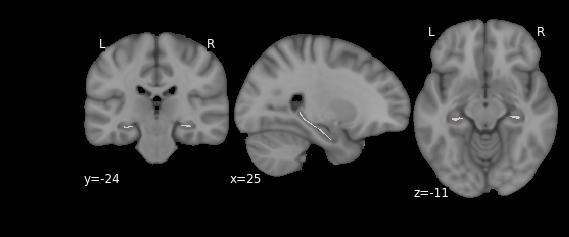

In [135]:
ap_axis = ni.load('/Users/jakevogel/Science/AHBA/blob_line_skel_1mm_2nii.nii')
#ap_axis = ni.load('/data1/users/jvogel/Allen_Human_Brain_Atlas/axis/blob_line_skel_1mm_2nii.nii')
#mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ap_axis, mni, draw_cross=False, cmap='Reds')
plt.show()

In [64]:
sample_coords = []
for i,row in df.iterrows():
    sample_coords.append(convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 'xyz'))
skel_coords = np.where(ap_axis.get_data() > 0)
y_location, closest_points = find_closest_point_along_axis(sample_coords,skel_coords)

In [67]:
df.loc[:,'position_along_hipp_AP_axis'] = y_location

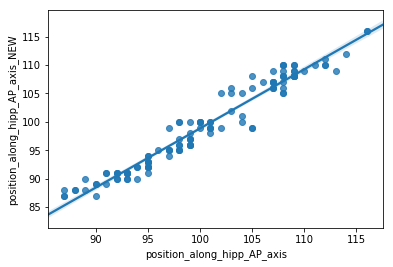

In [117]:
# how has it changed since after getting the correct (non-linear) coordinates?
match_df = df.loc[old_id]
plt.close()
sns.regplot(match_df.position_along_hipp_AP_axis, old_df.position_along_hipp_AP_axis_NEW)
plt.show()

# Run main analysis pipeline and evaluate

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


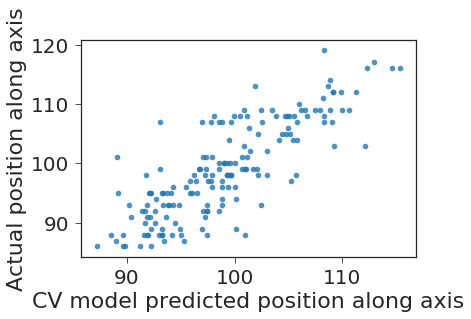

model cv score: r2 =  0.675885977482
running final model
final model fit r2 =  0.876810509326


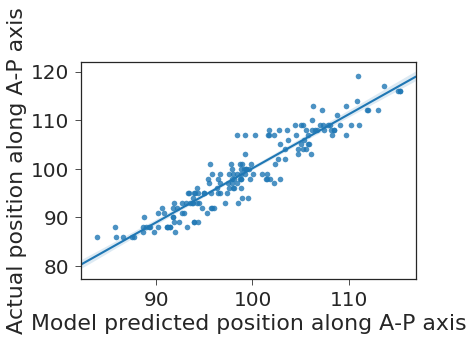

running sanity_check


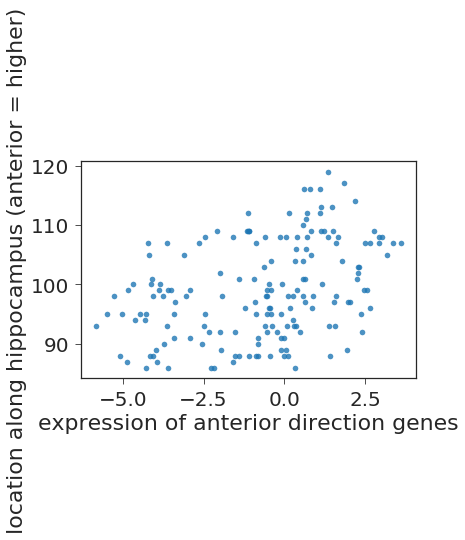

anterior 1 genes vs. y:  r2 = 0.146291960145, p = 2.64362300167e-07 




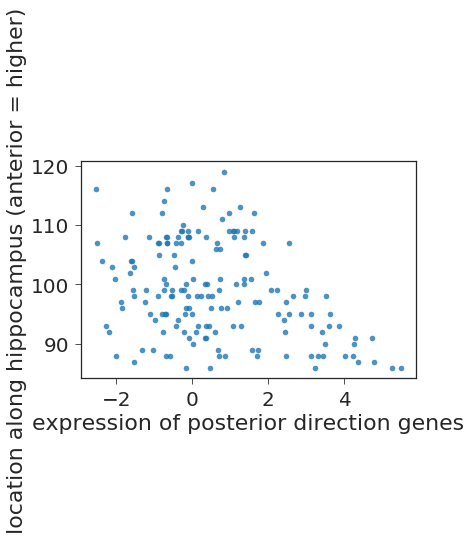

posterior 1 genes vs. y:  r2 = 0.120839023188, p = 3.40674823134e-06 




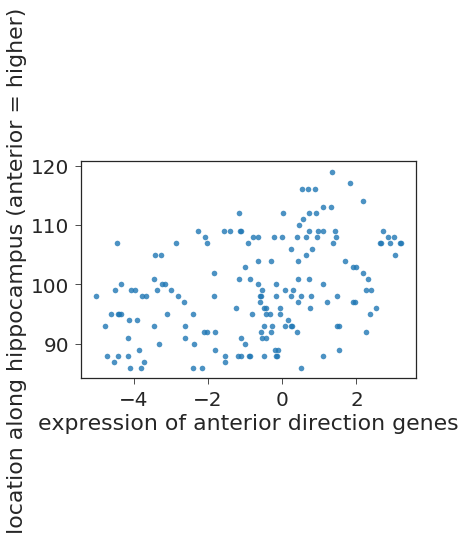

anterior 2 genes vs. y:  r2 = 0.156810463199, p = 9.03376115525e-08 




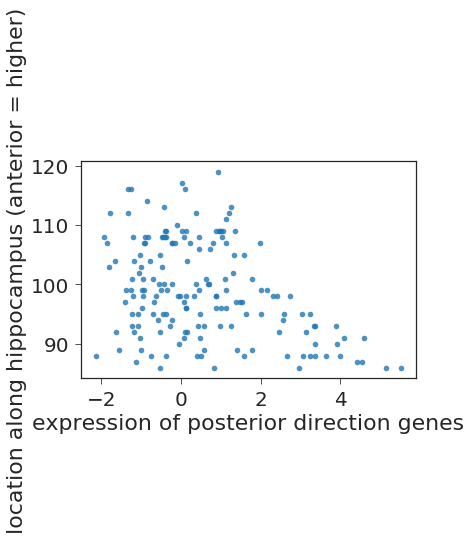

posterior 2 genes vs. y:  r2 = 0.140782455333, p = 4.61980605763e-07 




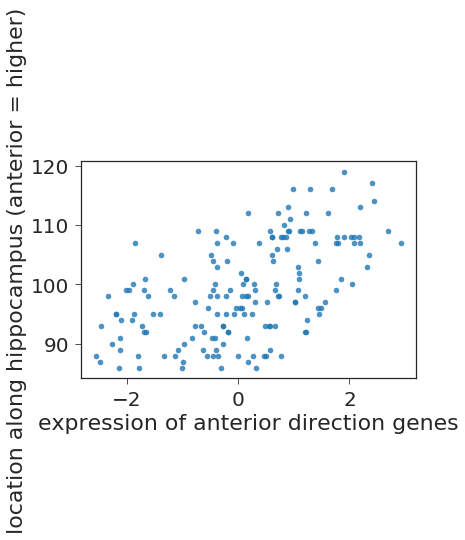

anterior 5 genes vs. y:  r2 = 0.312027641285, p = 2.46628262071e-15 




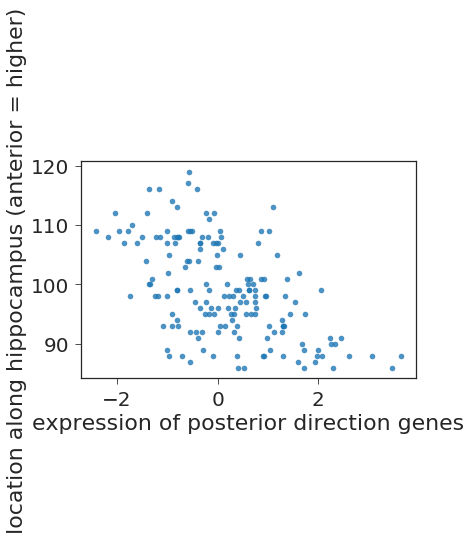

posterior 5 genes vs. y:  r2 = 0.308872084395, p = 3.6401288821e-15 




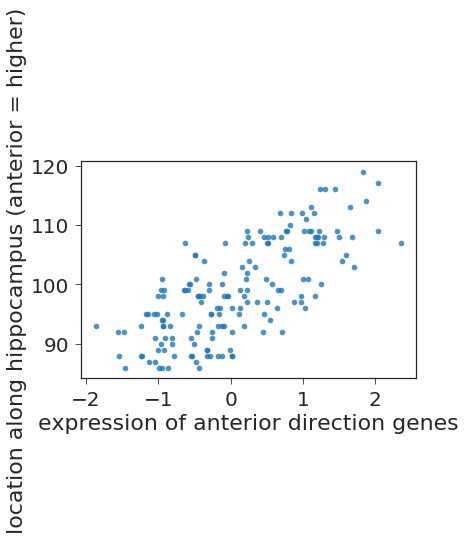

anterior 10 genes vs. y:  r2 = 0.541743338152, p = 2.83625582234e-30 




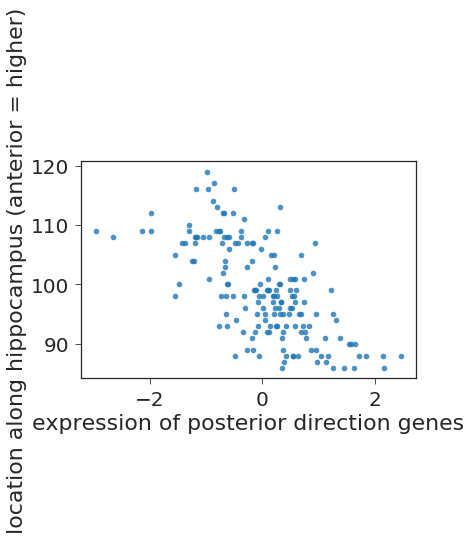

posterior 10 genes vs. y:  r2 = 0.45513306654, p = 6.38206163432e-24 




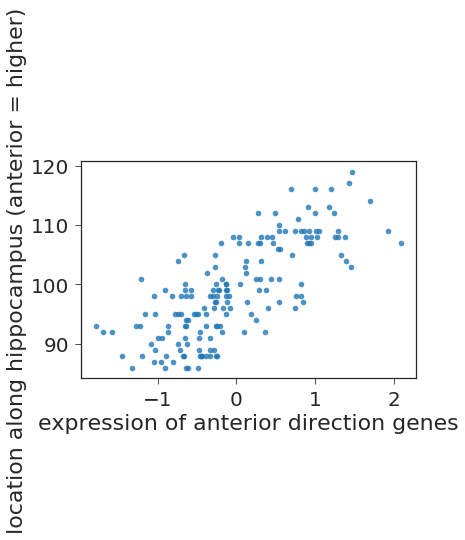

anterior 20 genes vs. y:  r2 = 0.577277974194, p = 3.12395740458e-33 




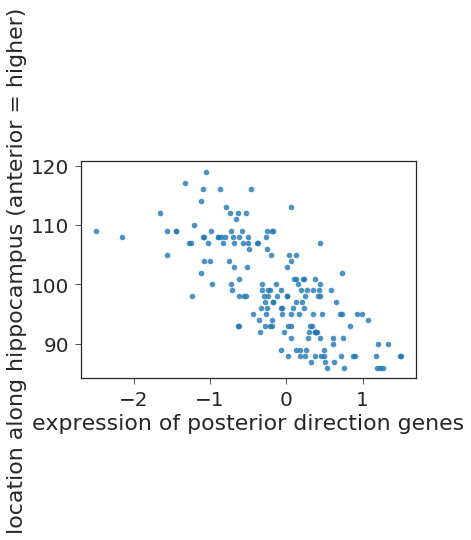

posterior 20 genes vs. y:  r2 = 0.528759540293, p = 3.00011527119e-29 




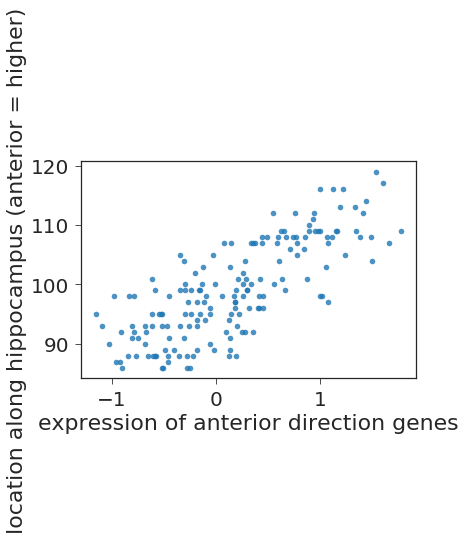

anterior 50 genes vs. y:  r2 = 0.604781566638, p = 1.07277863382e-35 




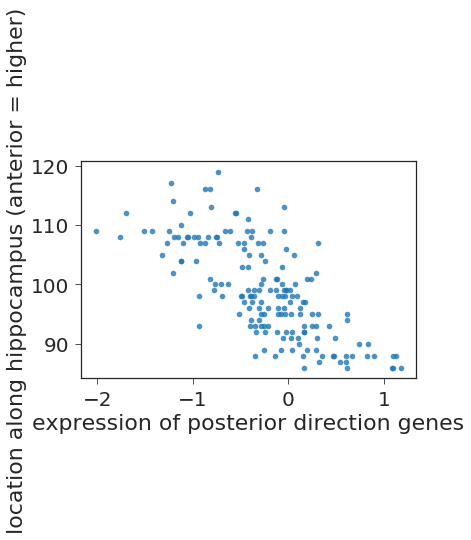

posterior 50 genes vs. y:  r2 = 0.521495808996, p = 1.09169856187e-28 




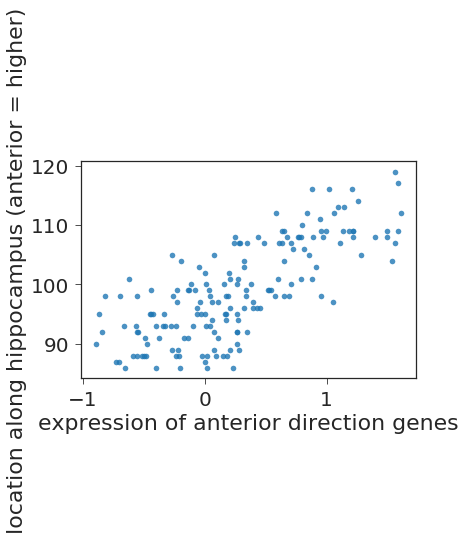

anterior 100 genes vs. y:  r2 = 0.568535370196, p = 1.75686862748e-32 




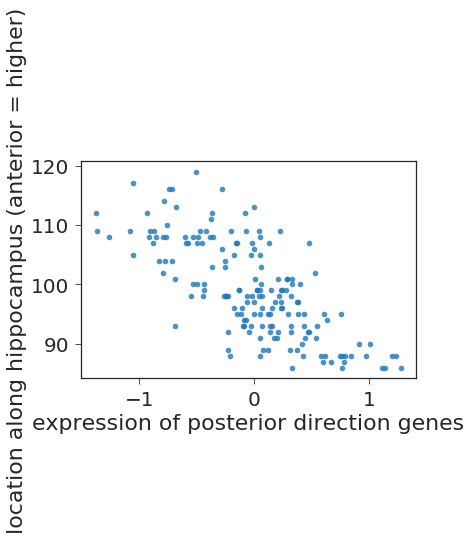

posterior 100 genes vs. y:  r2 = 0.530569444547, p = 2.16785299609e-29 




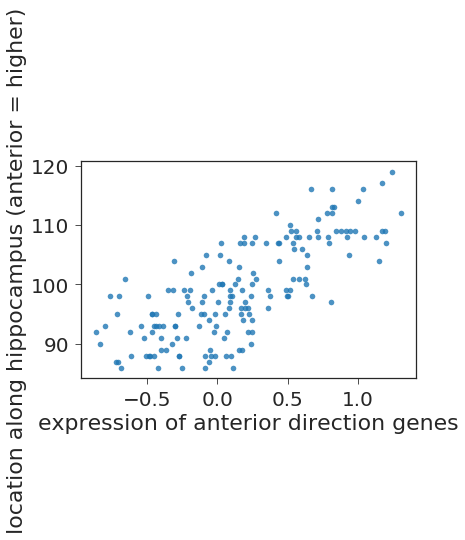

anterior 200 genes vs. y:  r2 = 0.573989954195, p = 6.00589222139e-33 




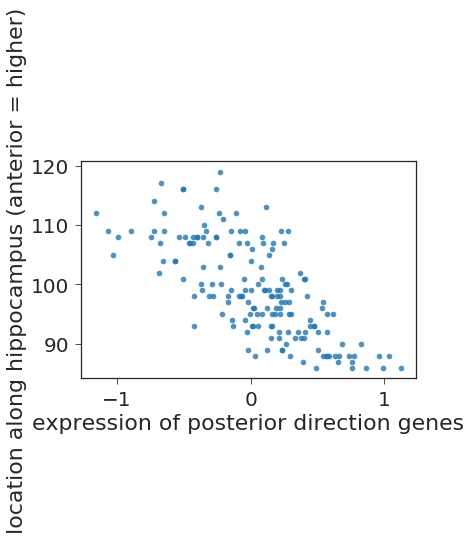

posterior 200 genes vs. y:  r2 = 0.530012749169, p = 2.396015094e-29 




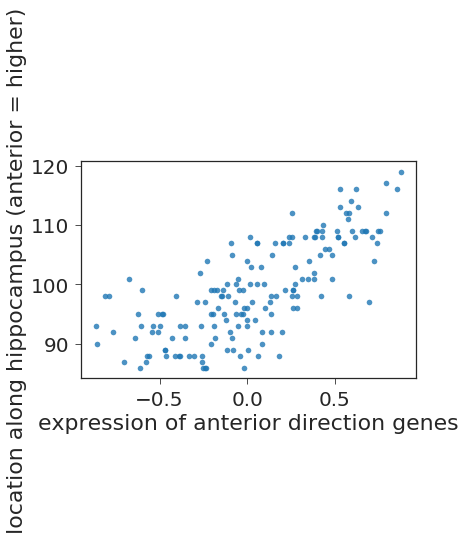

anterior 500 genes vs. y:  r2 = 0.561315373964, p = 7.1262999131e-32 




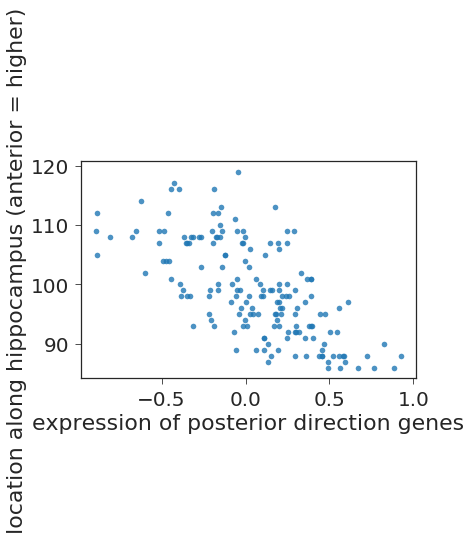

posterior 500 genes vs. y:  r2 = 0.456701046713, p = 5.00149396762e-24 




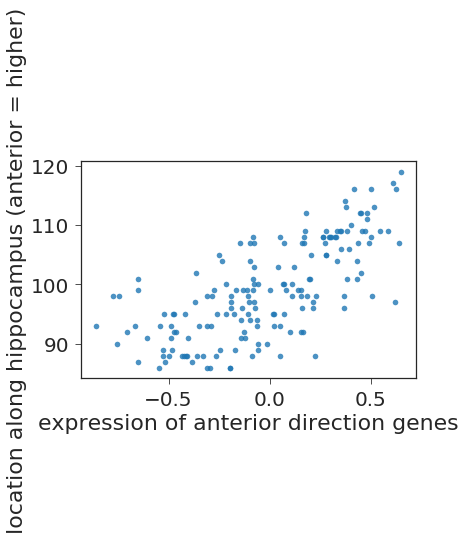

anterior 1000 genes vs. y:  r2 = 0.506219222541, p = 1.5519698984e-27 




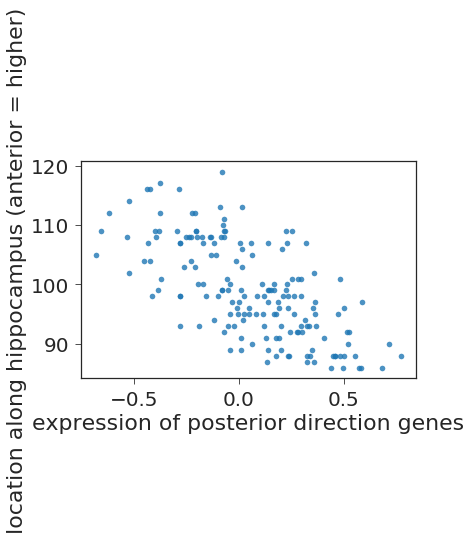

posterior 1000 genes vs. y:  r2 = 0.454418293527, p = 7.13048262374e-24 




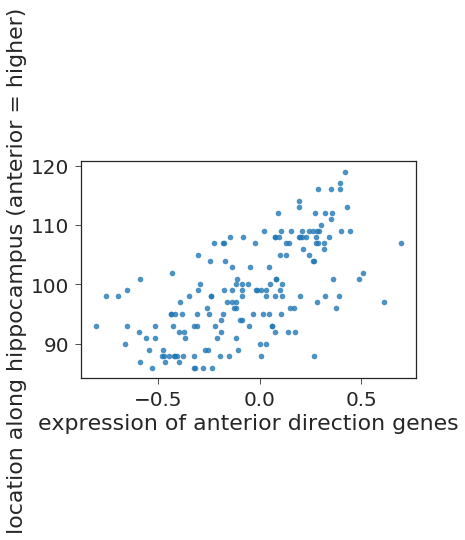

anterior 2000 genes vs. y:  r2 = 0.413582900724, p = 3.20747873988e-21 




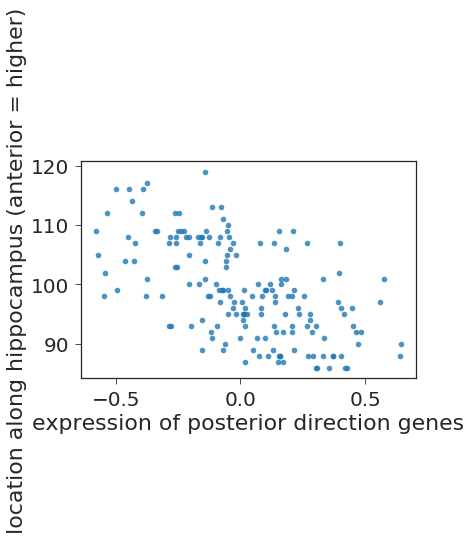

posterior 2000 genes vs. y:  r2 = 0.348659261806, p = 2.35874690133e-17 




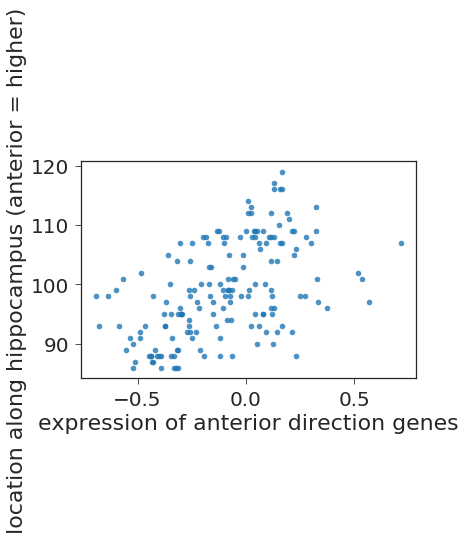

anterior 5000 genes vs. y:  r2 = 0.260250683548, p = 1.19416253845e-12 




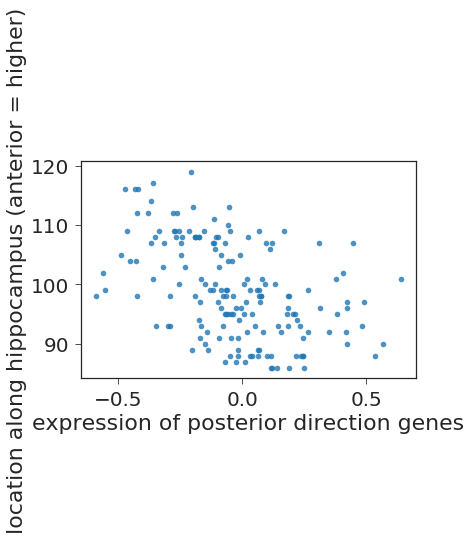

posterior 5000 genes vs. y:  r2 = 0.227039856261, p = 5.09894187119e-11 




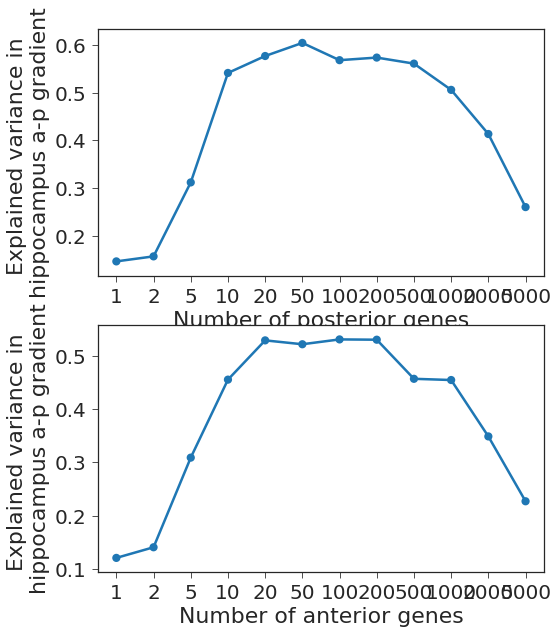

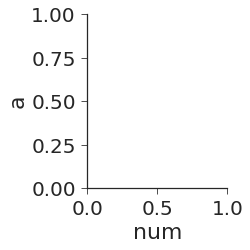

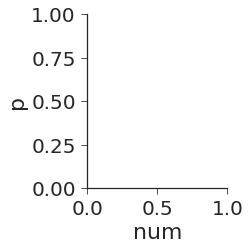

In [773]:
pcalr_out_NEW = PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                               sanity_check_style = 'separate')

In [30]:
comps = pandas.DataFrame(pcalr_out_NEW['pca_object'].components_.T,index=probes.index)
comps.loc[:,'symbol'] = probes.loc[:,'gene_symbol']

In [68]:
xp.T.shape

(170, 58692)

In [71]:
pca_tfm_xp = pandas.DataFrame(pcalr_out_NEW['pca_object'].transform(xp.T), 
                              index = xp.columns)
pca_tfm_xp.loc[:,'position'] = df.position_along_hipp_AP_axis.values
pca_tfm_xp.loc[:,'subfield'] = df.structure_acronym.values
pca_tfm_xp.head()

0           1          2          3          4          5  \
10021_20 -44.689160  -22.788990 -57.437276  73.575105 -53.796792  32.050365   
10021_21 -27.443255  -26.596743 -60.900451   8.055082 -68.368887 -38.725486   
10021_22 -50.112905  -51.647102 -46.346249  -3.471530 -96.591377  -9.892869   
10021_23 -14.877878  -39.598823 -40.115402   4.001682 -82.509002 -20.992467   
10021_24  65.555661 -126.747555   7.203998  77.349528 -66.832873 -12.498623   

                  6          7          8          9    ...          162  \
10021_20  52.724009   2.849483  80.319100 -23.444609    ...    -0.780796   
10021_21  39.571226 -61.955735  36.749681   4.266832    ...    -1.769595   
10021_22 -14.564665 -40.490075  53.371696  -3.229812    ...     0.884792   
10021_23 -22.428220 -44.189569  59.355522 -10.009728    ...    -4.608758   
10021_24 -17.666807 -52.213326  67.168066 -17.078968    ...     6.069365   

               163       164       165       166       167       168  \
10021_20 -0.081092  0.011010 -0.077932 -0.572741 -0.204324  0.503636   
10021_21  0.955105 -0.408133 -0.688776 -1.786932 -3.163025  0.322676   
10021_22 -1.695804 -0.347293 -1.130249  0.172244 -1.433416  0.730506   
10021_23 -0.326344  0.576957 -1.280214  0.721297 -0.862466 -0.360077   
10021_24  3.837481  2.759811  4.741841  1.200919  5.901204 -3.657330   

                   169  position  subfield  
10021_20  5.095924e-14        86       CA1  
10021_21  4.365258e-14        86       CA2  
10021_22  3.996803e-14        86       CA3  
10021_23  4.590772e-14        86       CA4  
10021_24  5.268008e-14        86        DG  

[5 rows x 172 columns]

In [49]:
u_genes = np.unique(comps.symbol)
avg_comps = pandas.DataFrame(index = u_genes, columns = comps.columns[:-1])
jnk = pandas.DataFrame(comps[comps.columns[:-1]],copy=True)
jnk.index = comps.symbol
for i,gene in enumerate(u_genes):
    j = jnk.loc[gene]
    if type(j) == pandas.core.frame.DataFrame: 
        avg_comps.loc[gene] = j.mean()
    else:
        avg_comps.loc[gene] = j.values
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [63]:
Acomp16 = avg_comps[[16]].sort_values(16,ascending=False)
Acomp16.columns = ['t']
jnk = pandas.DataFrame(index=range(len(Acomp16.index)), columns = ['symbol','t'])
jnk.loc[:,'symbol'] = Acomp16.index
jnk.loc[:,'t'] = Acomp16['t'].values
jnk.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/GSEA_COMPONTENT_16.rnk', sep = '\t',index=False)

In [76]:
Acomp16 = avg_comps[[14]].sort_values(14,ascending=False)
Acomp16.columns = ['t']
jnk = pandas.DataFrame(index=range(len(Acomp16.index)), columns = ['symbol','t'])
jnk.loc[:,'symbol'] = Acomp16.index
jnk.loc[:,'t'] = Acomp16['t'].values
jnk.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/GSEA_COMPONTENT_14.rnk', sep = '\t',index=False)

In [54]:
avg_comps.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_AVG_Component_Matrix.csv')

In [24]:
list(zip(range(170),pcalr_out_NEW['final_model'].coef_))

[(0, -0.0086381224966354652),
 (1, 0.0071040881378765979),
 (2, 0.011606236733016707),
 (3, 0.027813115039063262),
 (4, 0.026958937605020071),
 (5, 0.020196258845416128),
 (6, -0.059318063824894206),
 (7, 0.051765019332281781),
 (8, 0.018560931186190961),
 (9, -0.033689320431090221),
 (10, 0.0049191911771241676),
 (11, -0.017944754798327796),
 (12, 0.031618706508003247),
 (13, -0.015910641133700869),
 (14, -0.2248392422800754),
 (15, -0.046679235277460193),
 (16, -0.16032402494651857),
 (17, 0.0091400481934740402),
 (18, 0.040688938811796846),
 (19, 0.12114479774748016),
 (20, 0.040206966051852436),
 (21, -0.0012892416800620069),
 (22, -0.029395048988054544),
 (23, -0.1291086224228303),
 (24, 0.0),
 (25, 0.0078504884657917603),
 (26, -0.080041986328582879),
 (27, 0.045643689547986754),
 (28, 0.012889567573239254),
 (29, 0.0),
 (30, -0.0),
 (31, 0.095457130333338178),
 (32, -0.0),
 (33, 0.0043425958028348623),
 (34, -0.0),
 (35, -0.012900126482208075),
 (36, -0.0),
 (37, -0.042088202259

running PCA
transforming data
performing model cross-validation
using 10 iterations of 10-fold cross-validation


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 1
completed iteration 2


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 3
completed iteration 4


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 5


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 6


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 7
completed iteration 8
completed iteration 9
completed iteration 10


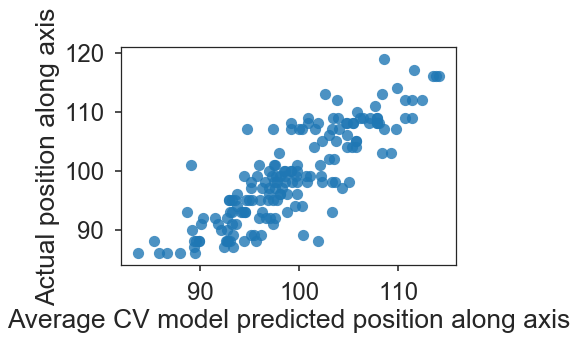

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


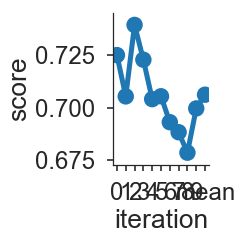

model cv scores (r2):
[0.72498247033534724, 0.70529712426358138, 0.73935976682315552, 0.72277965545537726, 0.70398894919691668, 0.7053545595861388, 0.69300251147356873, 0.68822074244319387, 0.67846727666597972, 0.69955235596508725]
average r2: 0.706100541221
running final model
final model fit r2 =  0.876810509326


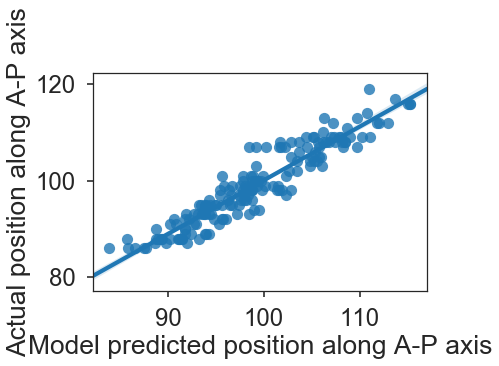

running sanity_check


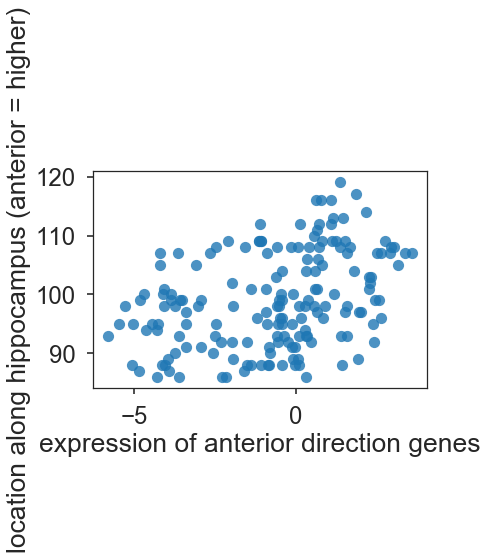

anterior 1 genes vs. y:  r2 = 0.146291960145, p = 2.64362300167e-07 




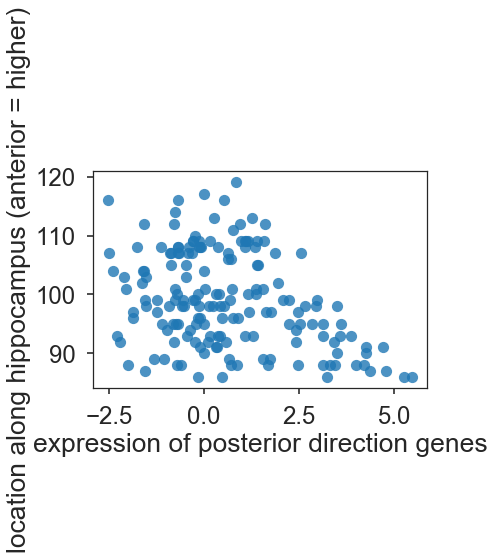

posterior 1 genes vs. y:  r2 = 0.120839023188, p = 3.40674823134e-06 




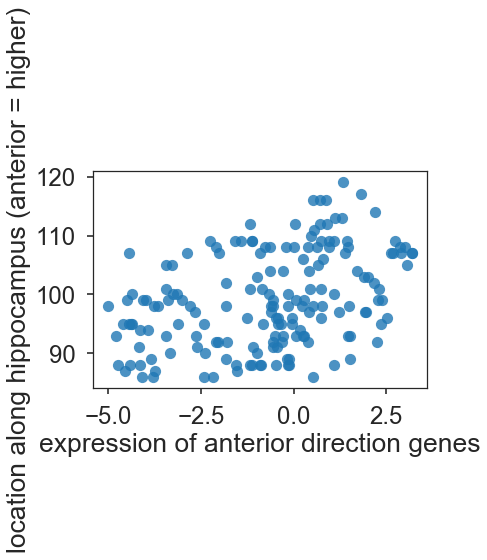

anterior 2 genes vs. y:  r2 = 0.156810463199, p = 9.03376115525e-08 




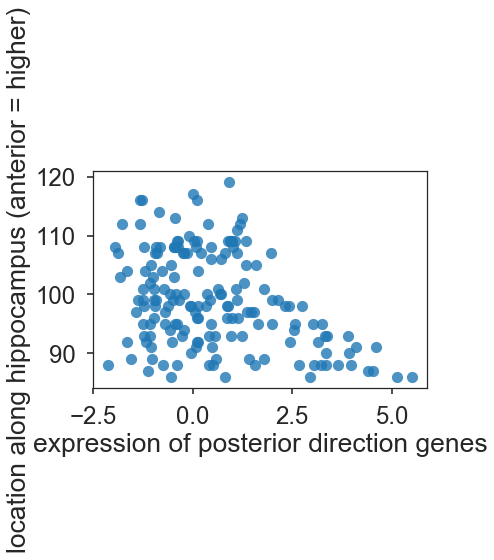

posterior 2 genes vs. y:  r2 = 0.140782455333, p = 4.61980605763e-07 




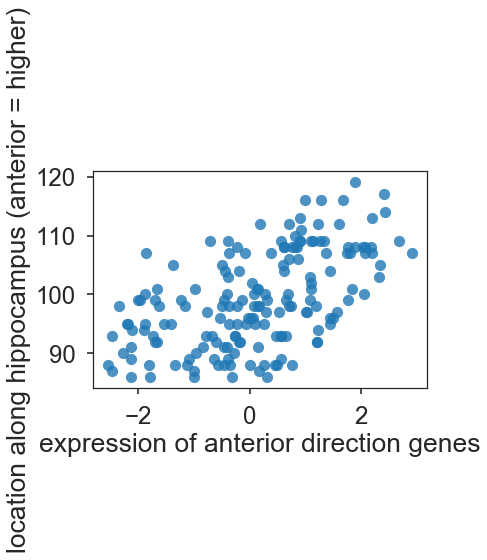

anterior 5 genes vs. y:  r2 = 0.312027641285, p = 2.46628262071e-15 




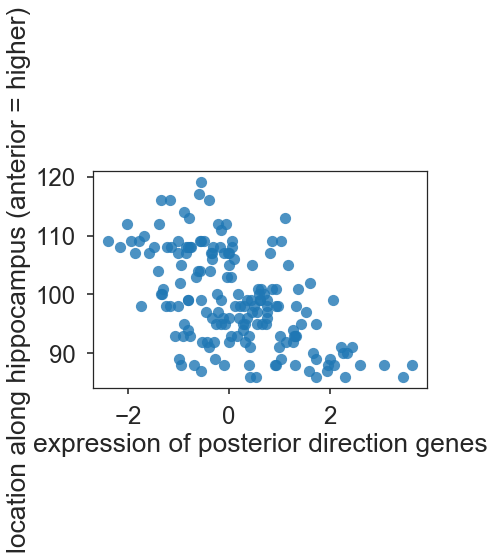

posterior 5 genes vs. y:  r2 = 0.308872084395, p = 3.6401288821e-15 




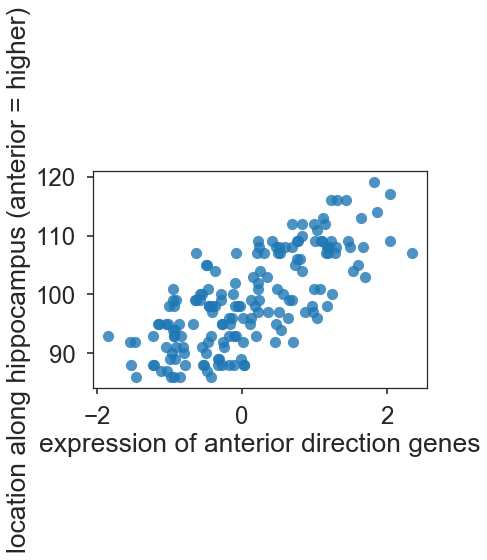

anterior 10 genes vs. y:  r2 = 0.541743338152, p = 2.83625582234e-30 




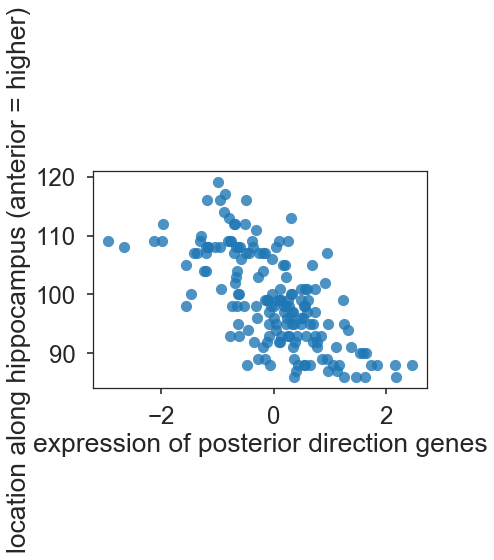

posterior 10 genes vs. y:  r2 = 0.45513306654, p = 6.38206163432e-24 




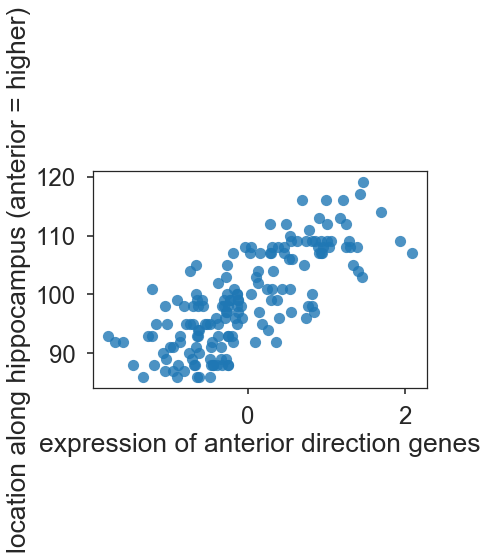

anterior 20 genes vs. y:  r2 = 0.577277974194, p = 3.12395740458e-33 




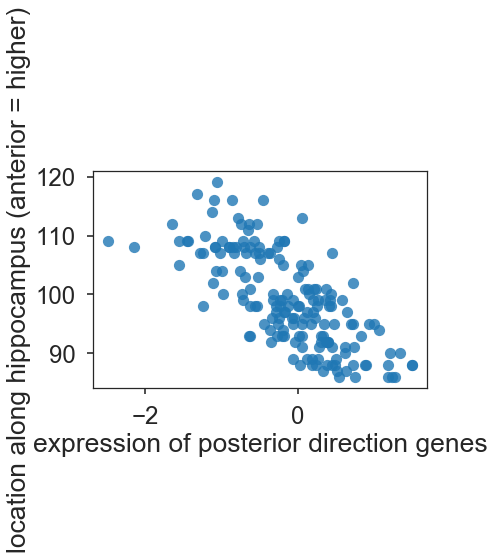

posterior 20 genes vs. y:  r2 = 0.528759540293, p = 3.00011527119e-29 




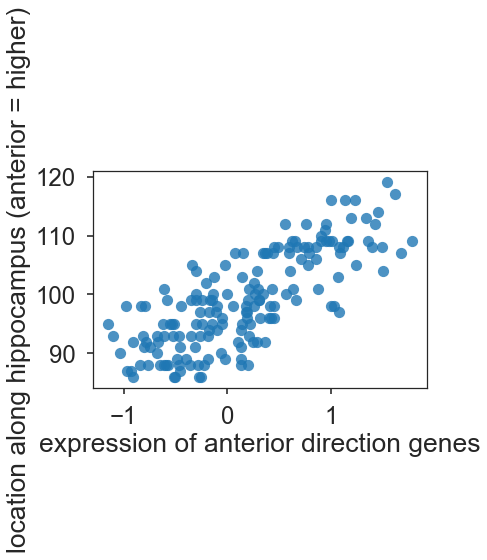

anterior 50 genes vs. y:  r2 = 0.604781566638, p = 1.07277863382e-35 




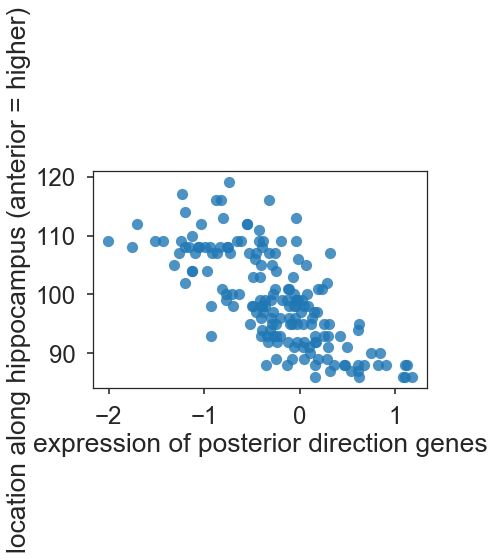

posterior 50 genes vs. y:  r2 = 0.521495808996, p = 1.09169856187e-28 




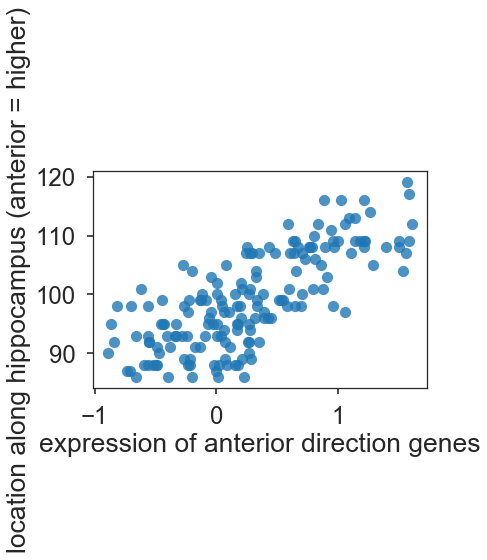

anterior 100 genes vs. y:  r2 = 0.568535370196, p = 1.75686862748e-32 




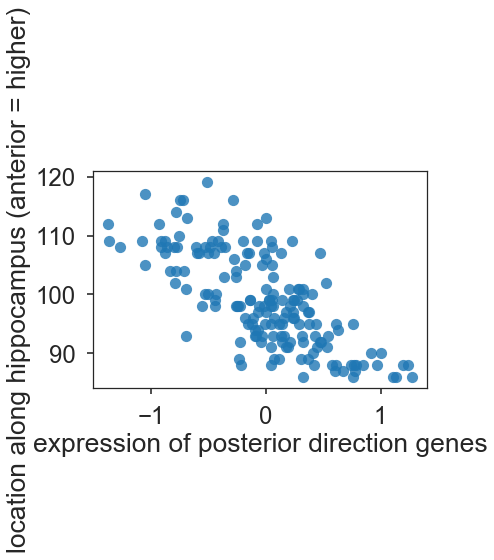

posterior 100 genes vs. y:  r2 = 0.530569444547, p = 2.16785299609e-29 




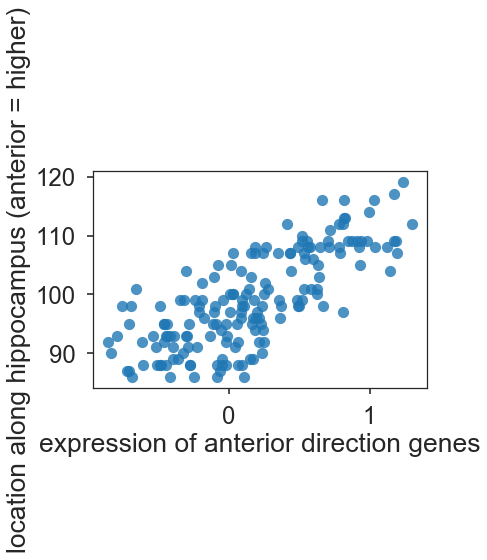

anterior 200 genes vs. y:  r2 = 0.573989954195, p = 6.00589222139e-33 




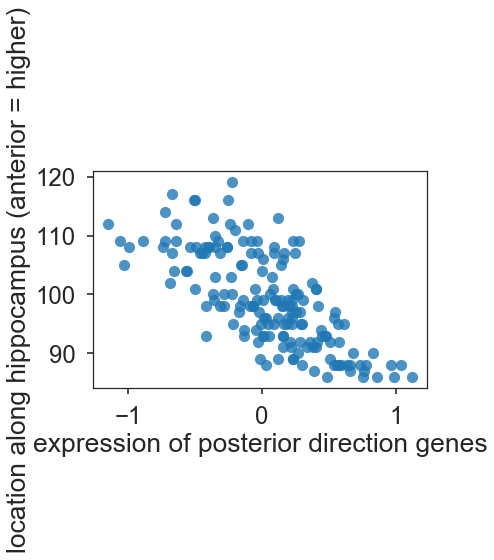

posterior 200 genes vs. y:  r2 = 0.530012749169, p = 2.396015094e-29 




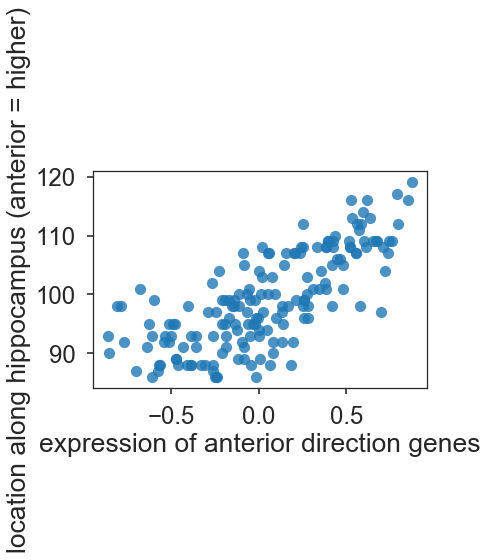

anterior 500 genes vs. y:  r2 = 0.561315373964, p = 7.1262999131e-32 




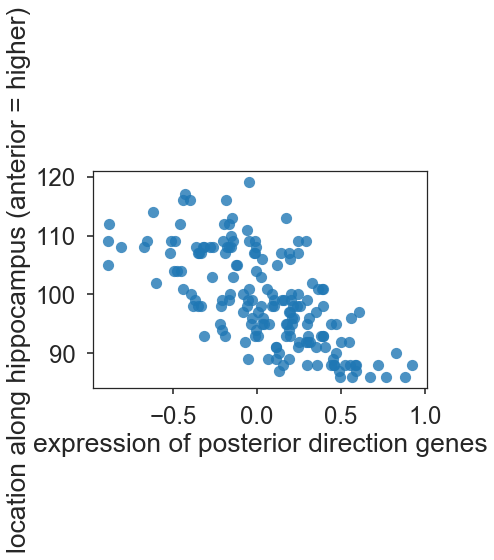

posterior 500 genes vs. y:  r2 = 0.456701046713, p = 5.00149396762e-24 




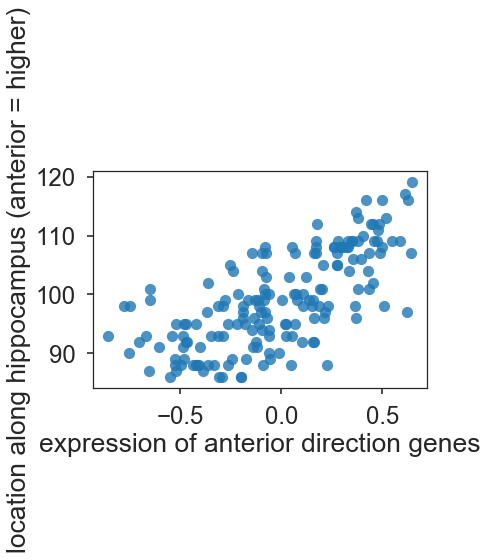

anterior 1000 genes vs. y:  r2 = 0.506219222541, p = 1.5519698984e-27 




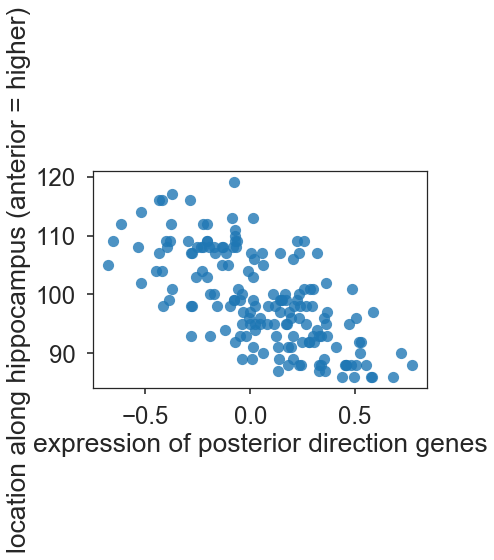

posterior 1000 genes vs. y:  r2 = 0.454418293527, p = 7.13048262374e-24 




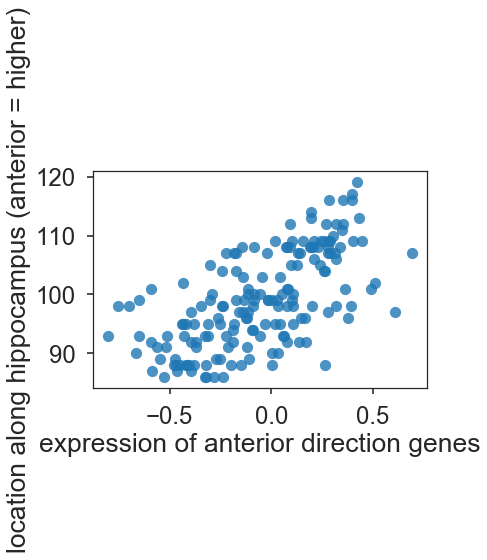

anterior 2000 genes vs. y:  r2 = 0.413582900724, p = 3.20747873988e-21 




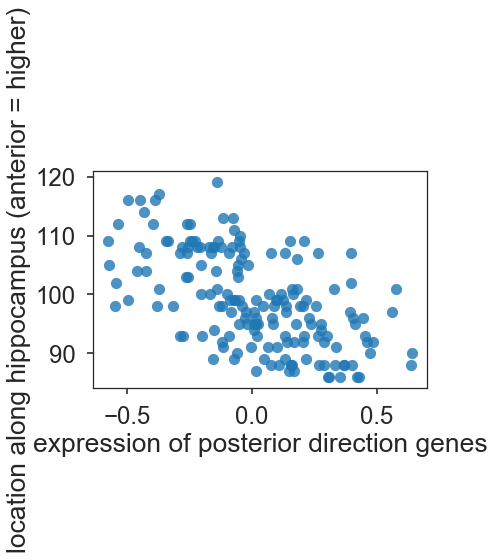

posterior 2000 genes vs. y:  r2 = 0.348659261806, p = 2.35874690133e-17 




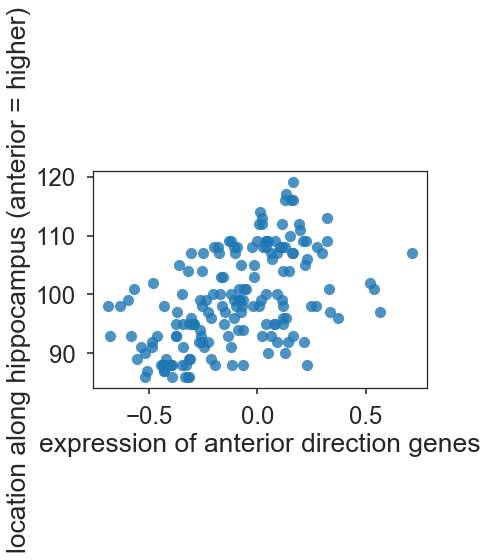

anterior 5000 genes vs. y:  r2 = 0.260250683548, p = 1.19416253845e-12 




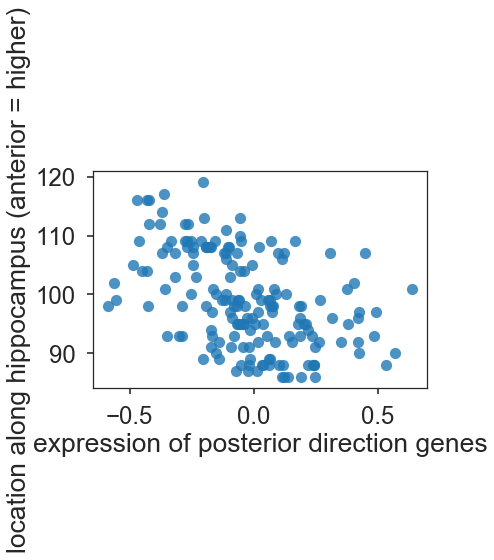

posterior 5000 genes vs. y:  r2 = 0.227039856261, p = 5.09894187119e-11 




//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


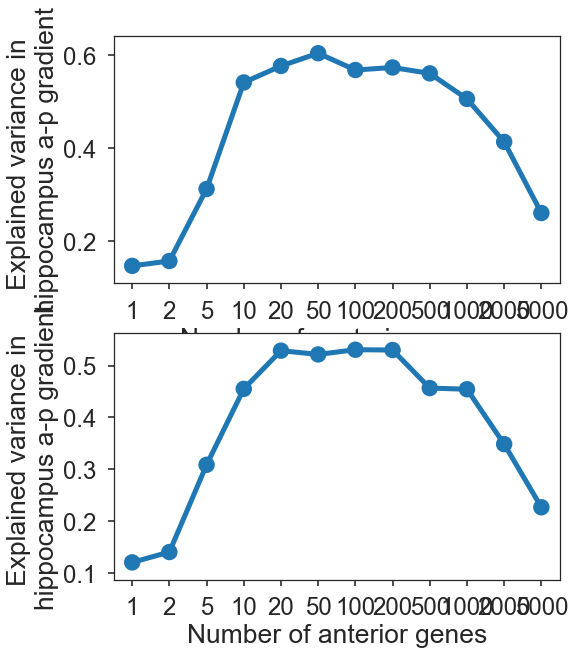

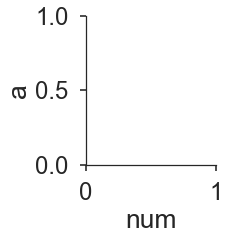

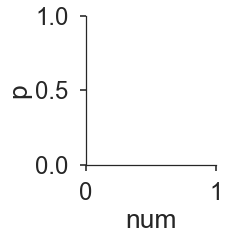

In [184]:
test = PCA_LR_pipeline(xp.values.T, 
                            df.position_along_hipp_AP_axis, 
                            cv_strategy=10, illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                               sanity_check_style = 'separate')

# Figures for manuscript...

In [679]:
clf = linear_model.LassoCV(random_state = 123)
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
cv=10
cv_strategy=10
y = df.position_along_hipp_AP_axis
score = []
preds = np.zeros((cv_strategy,len(y)))
for i in range(cv_strategy):
    sel = model_selection.KFold(n_splits=cv, shuffle=True)
    predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=sel)
    preds[i,:] = predicted
    score.append(stats.pearsonr(predicted, y)[0]**2)
    print('completed iteration',i+1)
score

completed iteration 1
completed iteration 2
completed iteration 3
completed iteration 4
completed iteration 5


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 6
completed iteration 7
completed iteration 8


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


completed iteration 9
completed iteration 10


[0.65624822667475868,
 0.71708873302578424,
 0.71815825166484826,
 0.69775392026938232,
 0.73223785270577746,
 0.71192876515797554,
 0.69383307042692854,
 0.72112362083526393,
 0.70036520010924064,
 0.69972911260333048]

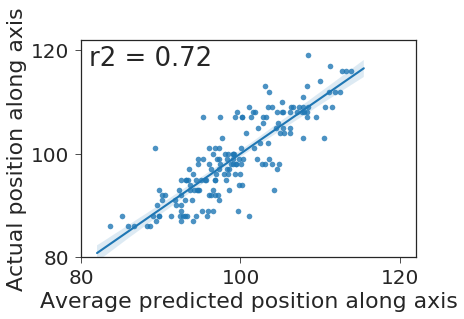

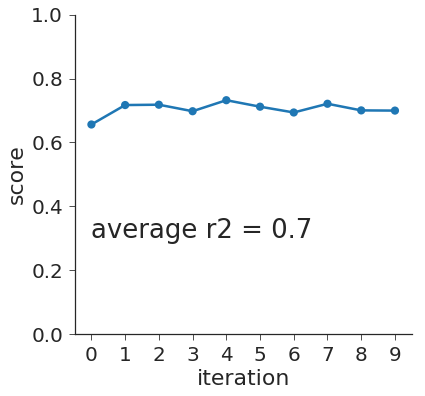

average r2: 0.704846675347
std r2: 0.0210082696361


In [685]:

plt.close()
sns.set_context('paper', font_scale=2.5)
sns.set_style('ticks')
sns.regplot(preds.mean(0), y, fit_reg=True)
plt.xlim(80,122)
plt.ylim(80,122)
plt.xticks(range(80,121,20))
plt.yticks(range(80,121,20))
plt.xlabel('Average predicted position along axis')
plt.ylabel('Actual position along axis')
r2 = np.float16(stats.pearsonr(preds.mean(0), y)[0]**2)
plt.text(81, 117,'r2 = %s'%(float('%.2g' % r2)), fontsize=26)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/model_cross_val_revised.pdf', 
            bbox_inches='tight')
plt.show()

jnk = pandas.DataFrame(index = range(cv_strategy), 
                       columns = ['score','iteration'])
jnk.loc[:,'iteration'] = list(range(cv_strategy))
jnk.loc[:,'score'] = score
plt.close()
sns.factorplot(x='iteration',y='score',data=jnk, size=6, aspect=1.1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.text(0, 0.3,'average r2 = %s'%(float('%.2g' % np.mean(score))), fontsize=26)
plt.show()
print('average r2:',np.mean(score))
print('std r2:', np.std(score,ddof=1))
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/avg_cross_val.pdf', 
#            bbox_inches='tight')

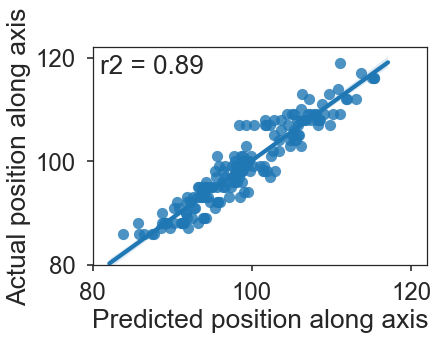

In [155]:
plt.close()
sns.regplot(pcalr_out_NEW['final_model'].predict(pca_tfm),y)
plt.xlim(80,122)
plt.ylim(80,122)
plt.xticks(range(80,121,20))
plt.yticks(range(80,121,20))
plt.xlabel('Predicted position along axis')
plt.ylabel('Actual position along axis')
r2 = np.float16(stats.pearsonr(pcalr_out_NEW['final_model'].predict(pca_tfm), y)[0]**2)
plt.text(81, 117,'r2 = %s'%(float('%.2g' % r2)), fontsize=26)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/full_model_fit.pdf', 
          bbox_inches='tight')
plt.show()

In [213]:
in_mtx.loc[sample,gene]

-2.2841113491608147

In [208]:
in_mtx.shape

(170, 58692)

In [240]:
in_mtx = xp.T.values
y = df.position_along_hipp_AP_axis
betas = pcalr_out_NEW['betas']
test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                200, 500, 1000, 2000, 5000,
                int(1e4), int(2e4), int(3e4), int(4e4), int(5e4)]
illustrative=False
#sanity_check_style = 'models'
sanity_check_style = 'separate'
reverse_axes=True
sns.set_context('poster')

if sanity_check_style == 'separate':
    ascores = []
    pscores = []
else:
    scores = []
print('running sanity_check')
betas = pandas.Series(betas)
outputs = {}
for num in test_gene_num:

    p_chk = betas.sort_values(ascending=False)[:num].index
    a_chk = betas.sort_values(ascending=False)[-num:].index

    pchk_vals = []
    achk_vals = []

    for sample in range(in_mtx.shape[0]):
        to_avg = []
        for gene in p_chk:
            to_avg.append(in_mtx[sample,gene])
        if sanity_check_style == 'model':
            pchk_vals.append(np.mean(np.array(to_avg) * betas.loc[p_chk].values))
        else:
            pchk_vals.append(np.mean(to_avg))

    for sample in range(in_mtx.shape[0]):
        to_avg = []
        for gene in a_chk:
            to_avg.append(in_mtx[sample,gene])
        if sanity_check_style == 'separate':
            achk_vals.append(np.mean(to_avg))
        elif sanity_check_style == 'model':
            achk_vals.append(np.mean(np.array(to_avg) * betas.loc[a_chk].values))
        else:
            achk_vals.append(np.mean(to_avg) * -1)

    if sanity_check_style != 'separate':
        chk_vals = np.array(pchk_vals) + np.array(achk_vals)

    if sanity_check_style == 'separate':
        pr,pp = stats.pearsonr(pchk_vals, y)
        if illustrative:
            plt.close()
            sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
            if reverse_axes:
                plt.xlabel('expression of anterior direction genes')
                plt.ylabel('location along hippocampus (anterior = higher)')
                plt.show()
                print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))
            else:
                plt.xlabel('expression of posterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
                print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

        ar,ap = stats.pearsonr(achk_vals, y)
        if illustrative:
            plt.close()
            sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
            if reverse_axes:
                plt.xlabel('expression of posterior direction genes')
                plt.ylabel('location along hippocampus (anterior = higher)')
                plt.show()
                print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            else:
                plt.xlabel('expression of anterior direction genes')
                plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
                print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))

    else:
        r,p = stats.pearsonr(chk_vals, y)
        if illustrative:
            plt.close()
            sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
            plt.xlabel('expression of A-P axis genes')
            if reverse_axes:
                plt.ylabel('location along hippocampus (anterior = higher)')
            else:
                plt.ylabel('location along hippocampus (posterior = higher)')
            plt.show()
            print('posterior and anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(
                                                                            num, r**2, p))

    if sanity_check_style == 'separate':
        if reverse_axes:
            ascores.append(pr**2)
            pscores.append(ar**2)
        else:
            ascores.append(ar**2)
            pscores.append(pr**2)
    else:
        scores.append(r**2)
    if reverse_axes:
        outputs.update({'posterior_genes_%s'%num: a_chk}) 
        outputs.update({'anterior_genes_%s'%num: p_chk})
    else:
        outputs.update({'posterior_genes_%s'%num: p_chk}) 
        outputs.update({'anterior_genes_%s'%num: a_chk})


running sanity_check


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


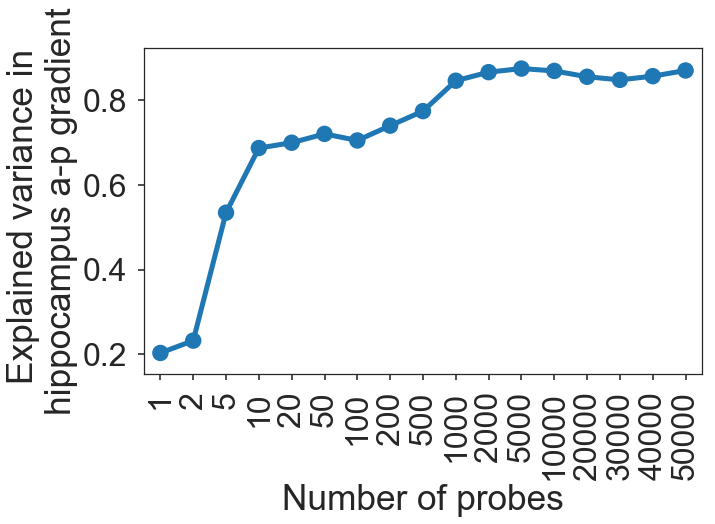

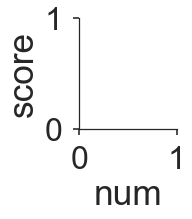

In [238]:

jnk = pandas.concat([pandas.Series(test_gene_num), 
                     pandas.Series(scores)
                    ],axis=1)
jnk.columns = ['num','score']

plt.close()
sns.set_context('poster',font_scale=2)
fig,ax1 = plt.subplots(figsize=(10,6))
sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
ax1.set(xlabel = 'Number of probes', 
        ylabel ='Explained variance in \nhippocampus a-p gradient')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
jnk=ax1.get_figure()
jnk.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/gene-variance_chart.pdf',
            bbox_inches='tight')
plt.show()



//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


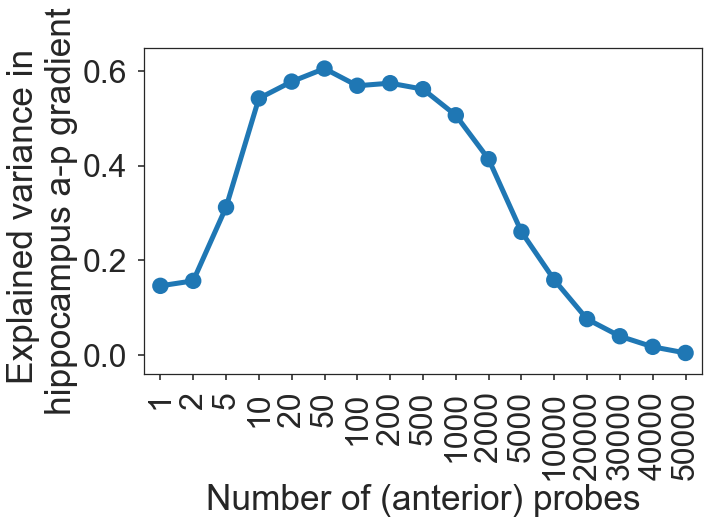

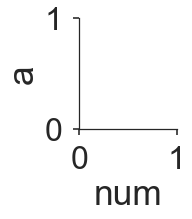

In [263]:
jnk = pandas.concat([pandas.Series(test_gene_num), 
                     pandas.Series(ascores),
                    pandas.Series(pscores)],axis=1)
jnk.columns = ['num','a','p']

plt.close()
sns.set_context('poster',font_scale=2)
#fig,(ax1,ax2) = plt.subplots(2, figsize=(10,6))
fig,ax1 = plt.subplots(1, figsize=(10,6))
sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
ax1.set(xlabel = 'Number of (anterior) probes', 
        ylabel ='Explained variance in \nhippocampus a-p gradient')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
f=ax1.get_figure()
f.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/gene-variance_ANT.pdf',
            bbox_inches='tight')
plt.show()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


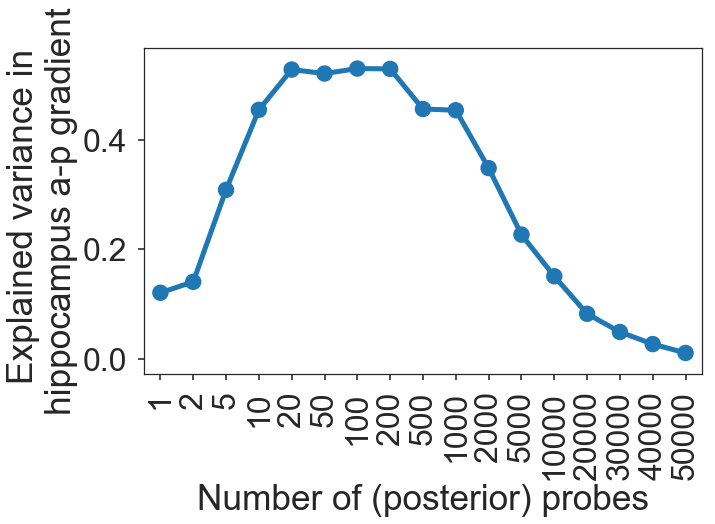

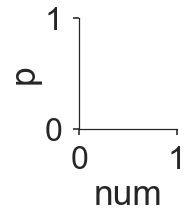

In [265]:
plt.close()
fig,ax2 = plt.subplots(1, figsize=(10,6))
sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
ax2.set(xlabel = 'Number of (posterior) probes', 
        ylabel ='Explained variance in \nhippocampus a-p gradient')

ax2.set_xticklabels(ax1.get_xticklabels(),rotation=90)
f=ax2.get_figure()
f.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/gene-variance_POST.pdf',
            bbox_inches='tight')
plt.show()

Making ready for figures...

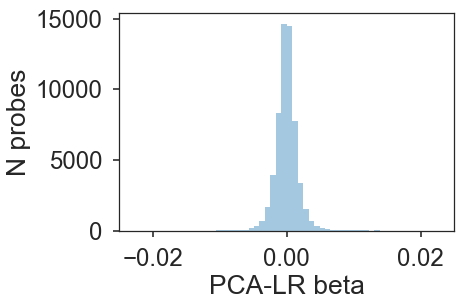

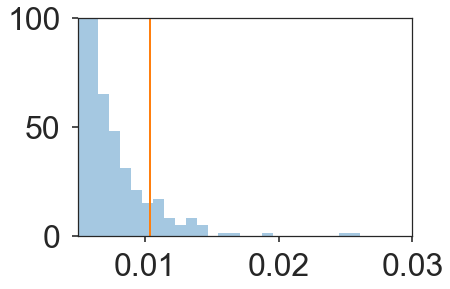

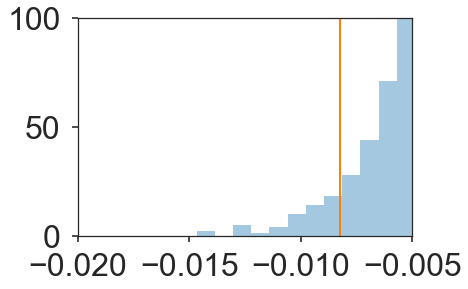

In [239]:

plt.close()
sns.set_context('poster',font_scale=1.5)
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(-0.025,0.025)
plt.xlabel('PCA-LR beta')
plt.ylabel('N probes')
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/BetaDist.pdf',
           bbox_inches = 'tight')
plt.show()

plt.close()
sns.set_context('poster',font_scale=2)
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(0.005,0.030)
plt.ylim(0,100)
xval = sorted(pcalr_out_NEW['betas'])[-50]
plt.plot([xval, xval], [0, 100], linewidth=2)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/BetaDistL.pdf',
           bbox_inches='tight')
plt.show()

plt.close()
sns.set_context('poster',font_scale=2)
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(-0.02,-0.005)
plt.xticks([-0.02, -0.015, -0.01, -0.005])
plt.ylim(0,100)
xval = sorted(pcalr_out_NEW['betas'])[50]
plt.plot([xval, xval], [0, 100], linewidth=2)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/BetaDistR.pdf',
           bbox_inches='tight')
plt.show()

In [188]:
sorted(pcalr_out_NEW['betas'])[50]

-0.0082333457509253822

In [12]:
df.loc[:,'bilateral_structure_name'] = [x.split(',')[0] for x in df.structure_name.values]
df.bilateral_structure_name.head()

0        CA1 field
1        CA2 field
2        CA3 field
3        CA4 field
4    dentate gyrus
Name: bilateral_structure_name, dtype: object

In [277]:
df.loc[:,'bigdf_index'] = df.index
df.index = df.basic_idx

AttributeError: 'DataFrame' object has no attribute 'basic_idx'

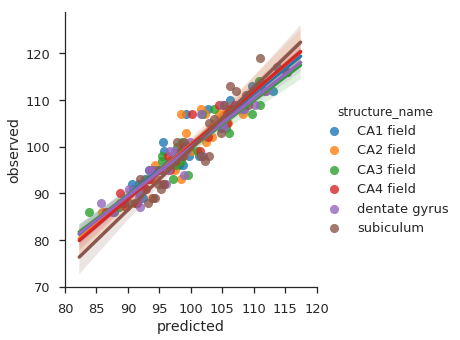

In [13]:
sns.set_context('talk')
sns.set_style('ticks')
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df.bilateral_structure_name], axis=1)
jnk.columns = ['predicted','observed','structure_name']
plt.close()
sns.lmplot(x='predicted', y='observed', hue='structure_name', data=jnk)
plt.xticks(range(80,125,5))
plt.show()

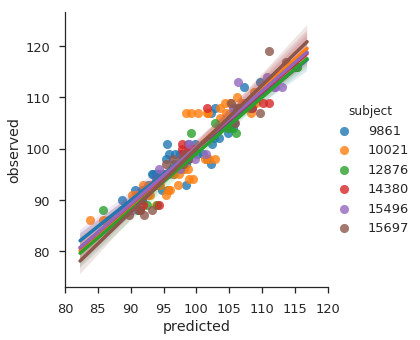

In [14]:
sns.set_context('talk')
sns.set_style('ticks')
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df['donor']], axis=1)
jnk.columns = ['predicted','observed','subject']
plt.close()
sns.lmplot(x='predicted', y='observed', hue='subject', data=jnk)
plt.xticks(range(80,125,5))
plt.show()

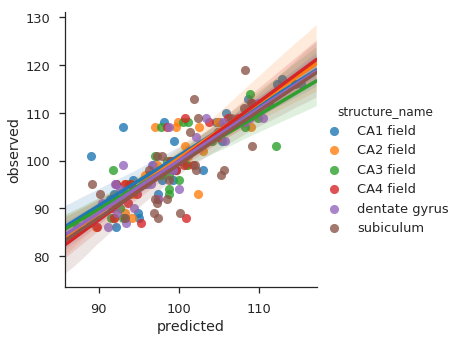

0.675885977482


In [15]:
predicted = model_selection.cross_val_predict(linear_model.LassoCV(random_state = 123), 
                                              pca_tfm, df.position_along_hipp_AP_axis, 
                                              cv=10)
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df.bilateral_structure_name], axis=1)
jnk.columns = ['predicted','observed','structure_name']
plt.close()
sns.lmplot(x='predicted', y='observed', hue='structure_name', data=jnk)
plt.show()
print(stats.pearsonr(jnk.observed, jnk.predicted)[0]**2)

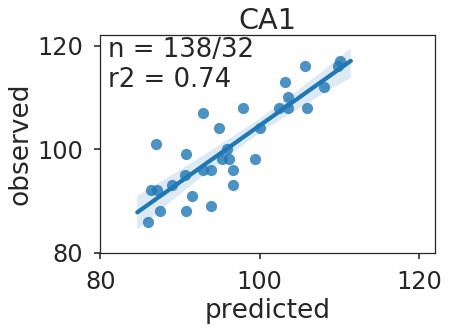

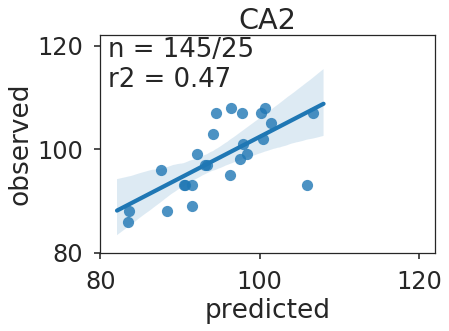

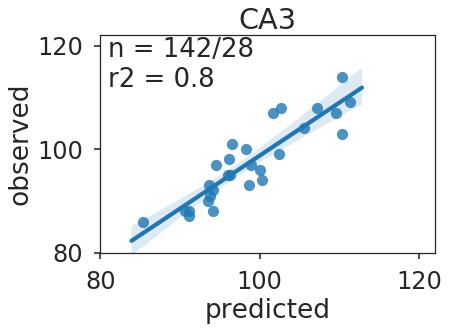

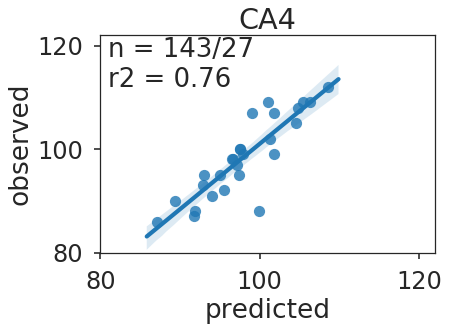

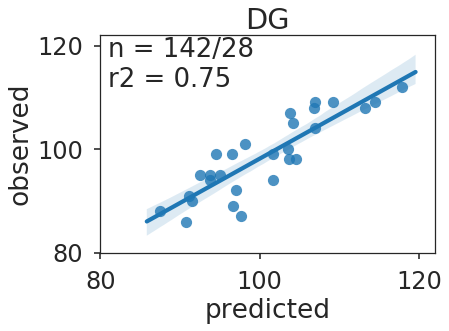

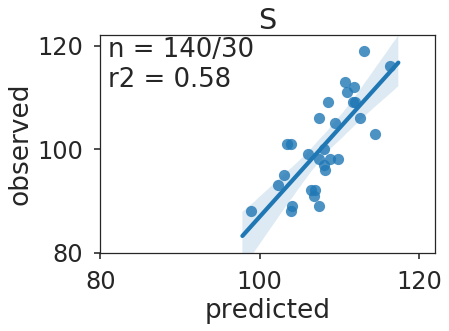

In [17]:
# LEAVE-ONE-SUBFIELD-OUT
# LEAVE ONE SUBFIELD OUT


te_ids = []
predz = []
clf = linear_model.LassoCV(random_state = 123)
for i,subfield in enumerate(df.structure_acronym.unique()):
    Tr_samps = df[df.structure_acronym!=subfield].index
    Te_samps = df[df.structure_acronym==subfield].index
    nX = len(Te_samps)
    nT = len(Tr_samps)
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    #sns.set(font_scale = 2)
    sns.set_context('poster', font_scale=1.5)
    sns.set_style('ticks')
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subfield)
    plt.xlim(80,122)
    plt.ylim(80,122)
    plt.xticks(range(80,121,20))
    plt.yticks(range(80,121,20))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    r2 = np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values
                                  )[0]**2)
    plt.text(81, 112,'n = %s/%s\nr2 = %s'%(nT,nX,float('%.2g' % r2)), fontsize=26)
    #plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/LOSO_%s.pdf'%subfield, 
    #            bbox_inches='tight')
    plt.show()

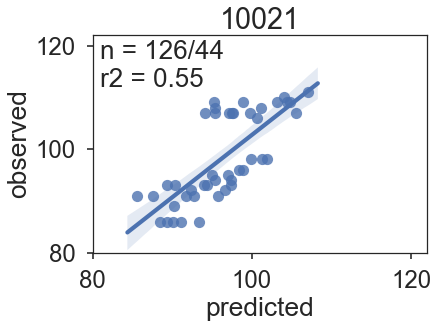

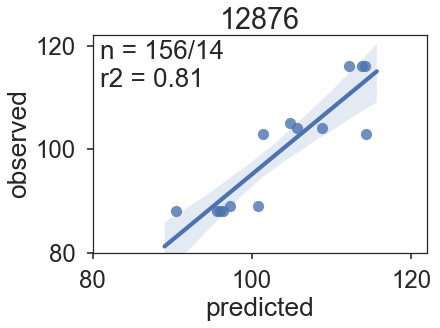

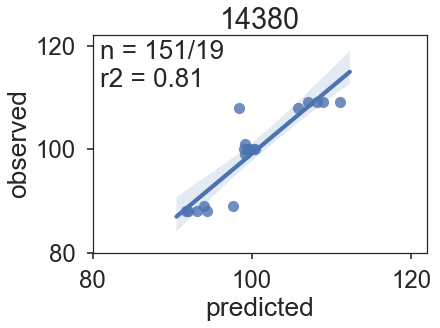

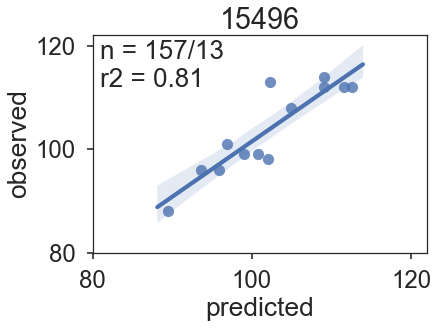

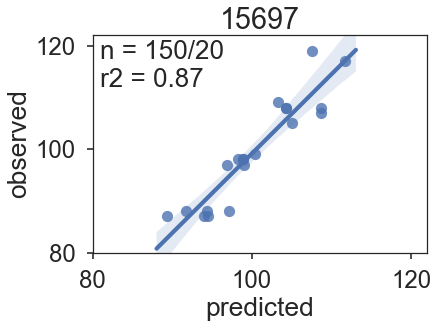

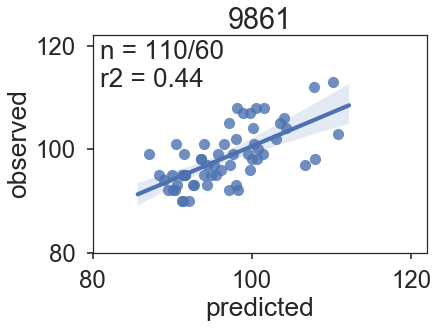

In [334]:
# LEAVE ONE SUBJECT OUT

te_ids = []
predz = []
clf = linear_model.LassoCV(random_state = 123)
for i,subject in enumerate(df['donor'].unique()):
    Tr_samps =  df[df['donor']!=subject].index
    Te_samps = df[df['donor']==subject].index
    X = pca_tfm[Tr_samps,:]
    nX = len(Te_samps)
    nT = len(Tr_samps)
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    #sns.set(font_scale = 2)
    sns.set_context('poster', font_scale=1.5)
    sns.set_style('ticks')
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subject)
    plt.xlim(80,122)
    plt.ylim(80,122)
    plt.xticks(range(80,121,20))
    plt.yticks(range(80,121,20))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    r2 = np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values
                                  )[0]**2)
    plt.text(81, 112,'n = %s/%s\nr2 = %s'%(nT,nX,float('%.2g' % r2)), fontsize=26)
    plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/LOSubO_%s.pdf'%subject, 
                bbox_inches='tight')
    plt.show()

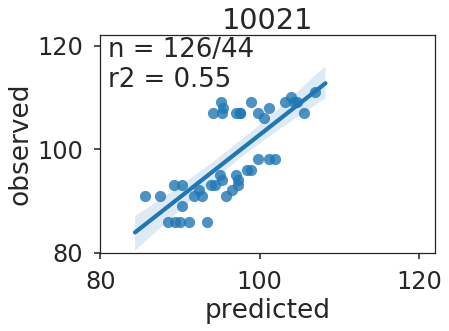

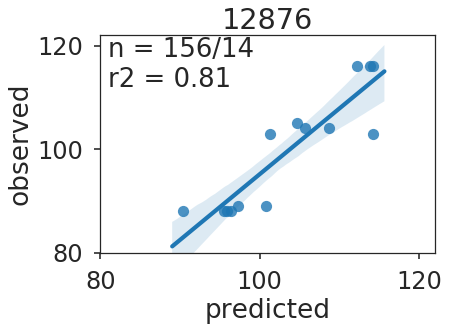

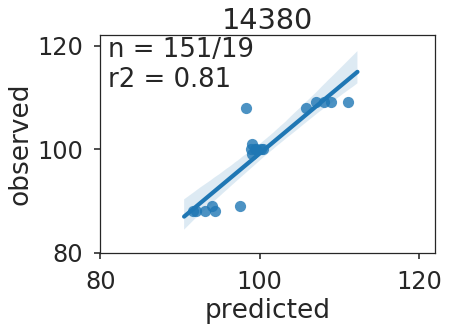

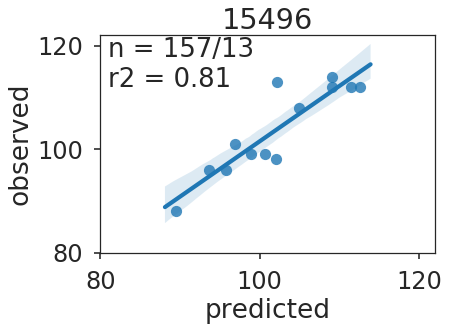

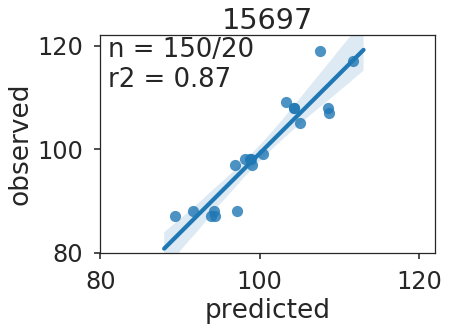

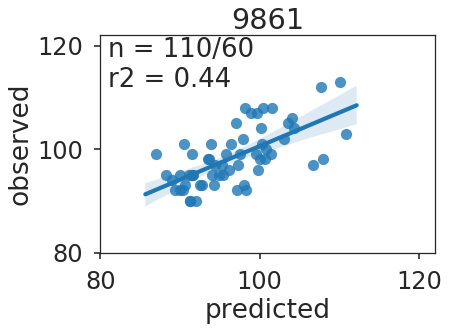

In [18]:
# LEAVE ONE SUBJECT OUT

te_ids = []
predz = []
clf = linear_model.LassoCV(random_state = 123)
for i,subject in enumerate(df['donor'].unique()):
    Tr_samps =  df[df['donor']!=subject].index
    Te_samps = df[df['donor']==subject].index
    X = pca_tfm[Tr_samps,:]
    nX = len(Te_samps)
    nT = len(Tr_samps)
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    #sns.set(font_scale = 2)
    sns.set_context('poster', font_scale=1.5)
    sns.set_style('ticks')
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subject)
    plt.xlim(80,122)
    plt.ylim(80,122)
    plt.xticks(range(80,121,20))
    plt.yticks(range(80,121,20))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    r2 = np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values
                                  )[0]**2)
    plt.text(81, 112,'n = %s/%s\nr2 = %s'%(nT,nX,float('%.2g' % r2)), fontsize=26)
    #plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/LOSubO_%s.pdf'%subject, 
    #            bbox_inches='tight')
    plt.show()

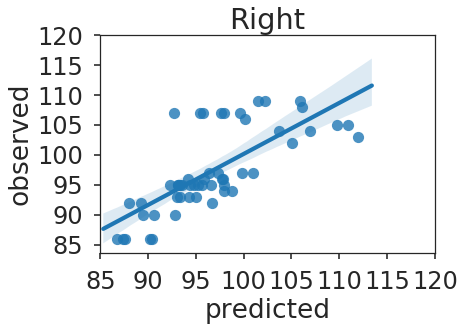

0.53955


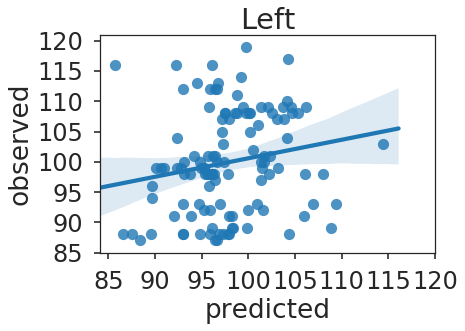

0.032898


In [19]:
# LEAVE ONE HEMISPHERE OUT
hemi = ['Left' if x < 0 else 'Right' for x in df.mni_nlin_x]
df.loc[:,'hemisphere'] = hemi
for hemisphere in df['hemisphere'].unique():
    Tr_samps =  df[df['hemisphere']!=hemisphere].index
    Te_samps = df[df['hemisphere']==hemisphere].index
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(hemisphere)
    plt.xticks(range(85,125,5))
    plt.yticks(range(85,125,5))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print(np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)[0]**2))

In [194]:
probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']]['gene_symbol'].tolist()

['SERPINF1',
 'SERPINF1',
 'KLK7',
 'RSPH9',
 'KLK7',
 'LYPD1',
 'GABRQ',
 'PYDC1',
 'SYTL2',
 'RP13-102H20.1',
 'SYTL2',
 'SSTR1',
 'LXN',
 'TMEM215',
 'SYTL2',
 'C1QL1',
 'PIRT',
 'KCNG1',
 'AQP3',
 'A_23_P213527',
 'RP11-45B20.3',
 'C1orf187',
 'GPR39',
 'OPRK1',
 'CD36',
 'AQP3',
 'KLK7',
 'MYB',
 'GPR26',
 'LMO1',
 'GPR88',
 'VGLL3',
 'NR2F2',
 'NR2F2',
 'NR2F2',
 'GPR83',
 'GDA',
 'NRG1',
 'RSPO2',
 'A_32_P136776',
 'C20orf103',
 'SYTL1',
 'LGALS2',
 'LXN',
 'GPR26',
 'KIAA1772',
 'A_32_P115840',
 'GDA',
 'SEMA3D',
 'NRG1']

In [16]:
probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']]['gene_symbol'].tolist()[::-1]

['NPNT',
 'NPNT',
 'TTR',
 'A_32_P11262',
 'BDKRB1',
 'SERTAD4',
 'NTN1',
 'HHIP',
 'HHIP',
 'RP11-561O23.6',
 'GRHL2',
 'RGMA',
 'BDKRB1',
 'BNC2',
 'TPBG',
 'OSBPL3',
 'NTN1',
 'ONECUT2',
 'COL5A2',
 'RP11-291L15.2',
 'FSTL4',
 'C1orf133',
 'DGKI',
 'DDC',
 'A_24_P401842',
 'A_32_P121537',
 'TNNT2',
 'FSTL4',
 'TTR',
 'HPSE2',
 'DDC',
 'DDC',
 'COL5A2',
 'WNT10A',
 'CASR',
 'DDC',
 'PVALB',
 'A_24_P62668',
 'FAM43B',
 'CTXN3',
 'DDC',
 'HPSE2',
 'GAL',
 'GREM2',
 'KDELR3',
 'COL5A2',
 'PDLIM5',
 'ONECUT2',
 'A_24_P102119',
 'GAL']

In [40]:
#g = pandas.ExcelFile('/Users/jakevogel/Science/AHBA/Top100_GeneHits.xlsx').parse('Sheet1')
g = pandas.ExcelFile('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/other_studies/Top100_GeneHits.xlsx'
                    ).parse('Sheet1')
g.head()

Post       Orig_P       Ant Orig_A
0    NPNT          NaN  SERPINF1    NaN
1    NPNT          NaN  SERPINF1    NaN
2     TTR          NaN      KLK7    NaN
3    HHIP  A_32_P11262     RSPH9    NaN
4  BDKRB1          NaN      KLK7    NaN

In [41]:
len(g.Post.tolist()) - len(g.Post.unique())

20

In [42]:
len(g.Ant.tolist()) - len(g.Ant.unique())

14

In [1037]:
# MAKE TABLE FOR OVERLEAF
p50 = probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']][['probe_id',
                                                                    'gene_symbol',
                                                                   'gene_name']]
p50.loc[:,'beta'] = sorted(pcalr_out_NEW['betas'])[:50][::-1]
a50 = probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']][['probe_id',
                                                                    'gene_symbol',
                                                                   'gene_name']]
a50.loc[:,'beta'] = sorted(pcalr_out_NEW['betas'])[-50:][::-1]
gene_table = pandas.concat([a50,p50])
#gene_table

In [44]:
for i,ind in enumerate(gene_table.index[:50]):
    if pandas.notnull(g.loc[g.index[i],'Orig_A']):
        nname = probes[probes.gene_symbol==g.loc[i,'Ant']]['gene_name'].values
        if len(nname)>0:
            gene_table.loc[ind,'gene_symbol'] = g.loc[i,'Ant']
            gene_table.loc[ind,'gene_name'] = nname[0]
for i,ind in enumerate(gene_table.sort_values('beta',ascending=True).index[:50]):
    if pandas.notnull(g.loc[g.index[i],'Orig_P']):
        nname = probes[probes.gene_symbol==g.loc[i,'Post']]['gene_name'].values
        if len(nname)>0:
            gene_table.loc[ind,'gene_symbol'] = g.loc[i,'Post']
            gene_table.loc[ind,'gene_name'] = nname[0]

In [45]:
gene_table.head(10)

probe_id    gene_symbol  \
4418    1053204       SERPINF1   
4417    1053205       SERPINF1   
25772   1030761           KLK7   
23274   1033144          RSPH9   
25771   1030762           KLK7   
20529   1036045          LYPD1   
15471   1041466          GABRQ   
24685   1032692          PYDC1   
14245   1042620          SYTL2   
22478   1034086  RP13-102H20.1   

                                               gene_name      beta  
4418   serpin peptidase inhibitor, clade F (alpha-2 a...  0.026119  
4417   serpin peptidase inhibitor, clade F (alpha-2 a...  0.025298  
25772                     kallikrein-related peptidase 7  0.019348  
23274        radial spoke head 9 homolog (Chlamydomonas)  0.016976  
25771                     kallikrein-related peptidase 7  0.016178  
20529                      LY6/PLAUR domain containing 1  0.014526  
15471   gamma-aminobutyric acid (GABA) A receptor, theta  0.014374  
24685                    PYD (pyrin domain) containing 1  0.014255  
14245                               synaptotagmin-like 2  0.013917  
22478                   Rho GTPase activating protein 36  0.013885

In [51]:
gene_table.sort_values('beta').head()

probe_id gene_symbol                     gene_name      beta short_beta
32889   1023030        NPNT                  nephronectin -0.014675    -0.0147
32888   1023031        NPNT                  nephronectin -0.014107    -0.0141
6582    1050553         TTR                 transthyretin -0.012919    -0.0129
51664   1064147        HHIP  hedgehog interacting protein -0.012902    -0.0129
44200   1058844      BDKRB1        bradykinin receptor B1 -0.012402    -0.0124

In [1040]:
a50.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/A50.csv')
p50.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/P50.csv')

In [ ]:
a50 = a50.sort_values('beta',ascending=False)
p50 = p50.sort_values('beta',ascending=True)
cols = ['probe_id','gene_symbol','beta']
for i in range(len(50)):
    
for i,row in a50.sort_values('beta', ascending=False)[cols].iterrows():
    line = '\\makecell{%s} '%row[0]
    for item in row[1:]:
        line += '& \makecell{%s} '%item
    line += "\\\\"
    print(line)

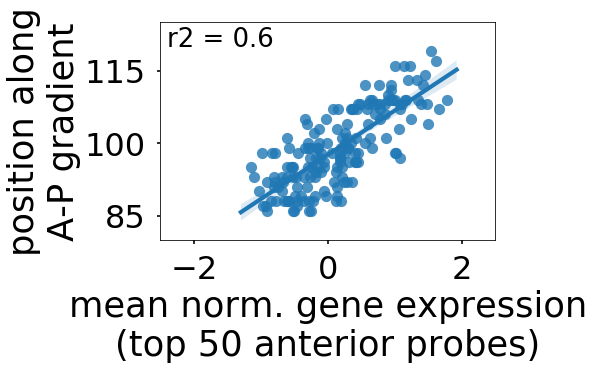

In [59]:
plt.close()
sns.set_context('poster',font_scale=2)
r2 = stats.pearsonr(xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']].mean(),
                    df.position_along_hipp_AP_axis)[0]**2
sns.regplot(xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']].mean(),
            df.position_along_hipp_AP_axis)
plt.xlabel('mean norm. gene expression\n(top 50 anterior probes)')
plt.ylabel('position along\nA-P gradient')
plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
plt.ylim(80,125)
plt.yticks([85,100,115])
plt.text(-2.4, 120,'r2 = %s'%float('%.2g'%r2), fontsize=26)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/ant50_position.pdf',
           bbox_inches='tight')
plt.show()

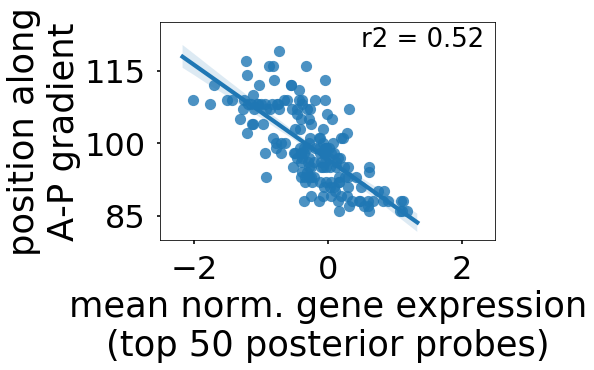

In [64]:
plt.close()
r2 = stats.pearsonr(xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']].mean(),
                    df.position_along_hipp_AP_axis)[0]**2
sns.regplot(xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']].mean(),
            df.position_along_hipp_AP_axis)
plt.xlabel('mean norm. gene expression\n(top 50 posterior probes)')
plt.ylabel('position along\nA-P gradient')
plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
plt.ylim(80,125)
plt.yticks([85,100,115])
plt.text(0.5, 120,'r2 = %s'%float('%.2g'%r2), fontsize=26)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/post50_position.pdf',
           bbox_inches='tight')
plt.show()

# Relative and absolute expression

In [101]:
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/PACall.csv')))
holder = []
for sht in shtz:
    jnk = pandas.read_csv(sht,header=None)
    jnk.drop(jnk.columns[0],axis=1,inplace=True)
    holder.append(jnk)
bigdf_b = pandas.concat(holder,axis=1)
del(holder)

In [92]:
hipp_samps = []
for col in xp.columns:
    jnk = col.split('_')
    sub = jnk[0]
    samp = jnk[-1]
    idx = gdf[(gdf.donor==int(sub)) & (gdf['sample']==int(samp))].index
    hipp_samps.append(idx[0])
#hipp_samps = list(np.array(hipp_samps) + 1)

In [102]:
bin_hipp = bigdf_b.iloc[:,hipp_samps]
bin_hipp.shape

(58692, 170)

In [103]:
del(bigdf_b)

In [104]:
bin_hipp_a = bin_hipp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']]
bin_hipp_p = bin_hipp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']]

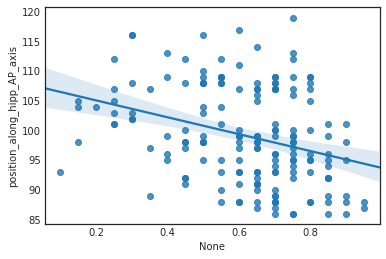

In [105]:
plt.close()
sns.regplot(bin_hipp_a.mean(),df.position_along_hipp_AP_axis)
plt.show()

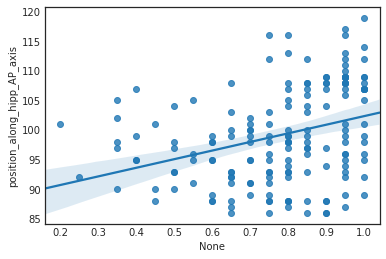

In [106]:
plt.close()
sns.regplot(bin_hipp_p.mean(),df.position_along_hipp_AP_axis)
plt.show()

In [107]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/MExp_all_genes_ctr_for_donor')))
holder = []
for sht in shtz:
    holder.append(pandas.read_csv(sht,index_col=0))
bigdf = pandas.concat(holder,axis=1)
del(holder)
ncols = ['%s_%s'%(gdf.loc[x,'donor'],bigdf.columns[x]) for x in range(gdf.shape[0])]
bigdf.columns = ncols

In [108]:
gx_hipp = bigdf.iloc[:,hipp_samps]
gx_hipp_a = gx_hipp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']]
gx_hipp_p = gx_hipp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']]

In [109]:
del(bigdf)

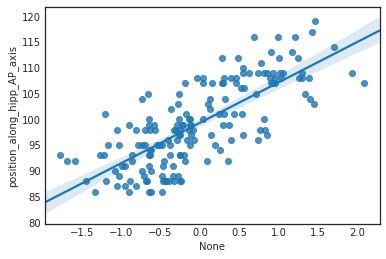

In [112]:
plt.close()
sns.regplot(gx_hipp_p.mean(),df.position_along_hipp_AP_axis)
plt.show()

-5.09279587183


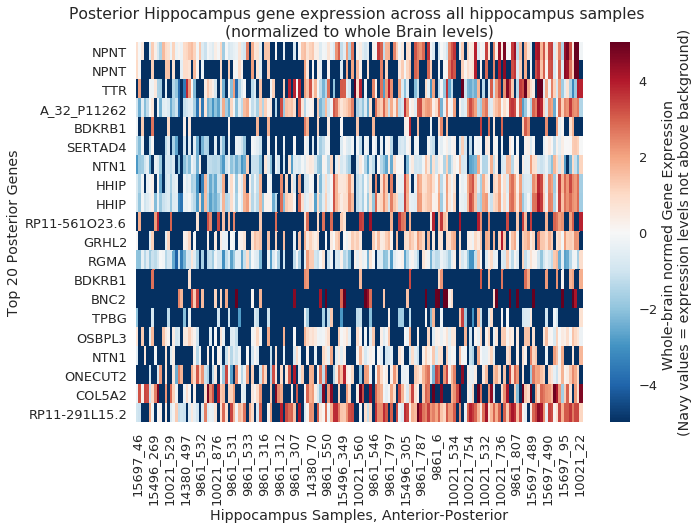

In [145]:
cutdf = pandas.DataFrame(gx_hipp_a,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_a.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]
minval = min(cutdf.values.flat)
print(minval)
    
cutdf1 = pandas.DataFrame(gx_hipp_a,copy=True)
for i in range(cutdf1.shape[0]):
    cutdf1.loc[cutdf1.index[i]] = [cutdf1.values[i,x] if bin_hipp_a.values[i,x] == 1 else -10 for x in range(cutdf1.shape[-1])]

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf1.loc[cutdf.index.tolist()[::-1],sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']
plotr

plt.close()
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',vmin = -5, vmax=5,
            cbar_kws={'label': 'Whole-brain normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Posterior Hippocampus gene expression across all hippocampus samples \n(normalized to whole Brain levels)')
plt.ylabel('Top 20 Posterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

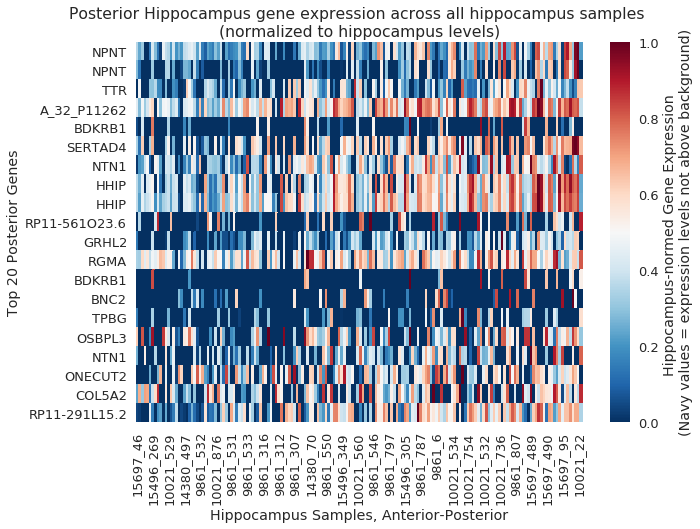

In [126]:
cutdf = pandas.DataFrame(gx_hipp_a,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_a.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]

mat = np.zeros_like(cutdf.values)
for i in range(cutdf.shape[0]):
    jnk = MinMaxScaler().fit(cutdf.loc[cutdf.index[i]].dropna().values.reshape(-1,1))
    for j,x in enumerate(cutdf.loc[cutdf.index[i]].values):
        if pandas.notnull(x):
            mat[i,j] = jnk.transform(x)
cutdf = pandas.DataFrame(mat, index = cutdf.index, columns = cutdf.columns)

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf.loc[cutdf.index.tolist()[::-1],sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',
            cbar_kws={'label': 'Hippocampus-normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Posterior Hippocampus gene expression across all hippocampus samples \n(normalized to hippocampus levels)')
plt.ylabel('Top 20 Posterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

-5.27886886052


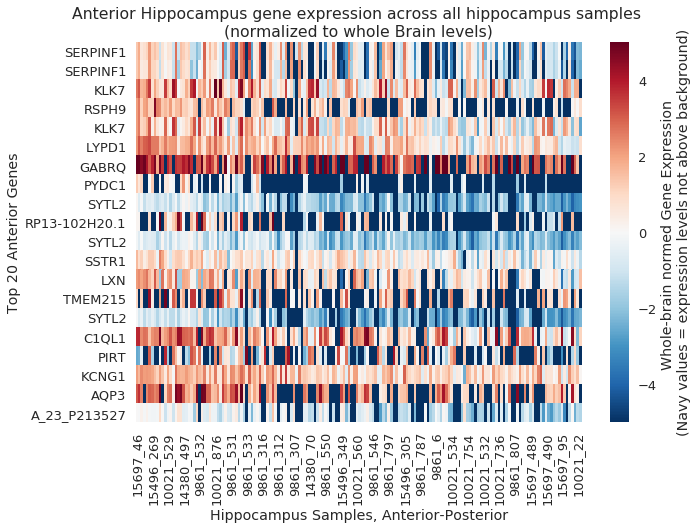

In [147]:
cutdf = pandas.DataFrame(gx_hipp_p,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_p.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]
minval = min(cutdf.values.flat)
print(minval)
    
cutdf1 = pandas.DataFrame(gx_hipp_p,copy=True)
for i in range(cutdf1.shape[0]):
    cutdf1.loc[cutdf1.index[i]] = [cutdf1.values[i,x] if bin_hipp_p.values[i,x] == 1 else -10 for x in range(cutdf1.shape[-1])]

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf1[sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',vmin = -5, vmax = 5, 
            cbar_kws={'label': 'Whole-brain normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Anterior Hippocampus gene expression across all hippocampus samples \n(normalized to whole Brain levels)')
plt.ylabel('Top 20 Anterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

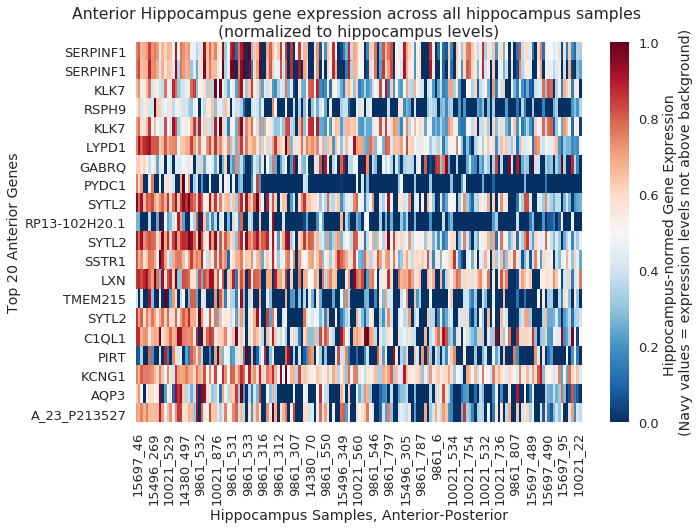

In [128]:
cutdf = pandas.DataFrame(gx_hipp_p,copy=True)
for i in range(cutdf.shape[0]):
    cutdf.loc[cutdf.index[i]] = [cutdf.values[i,x] if bin_hipp_p.values[i,x] == 1 else np.nan for x in range(cutdf.shape[-1])]

mat = np.zeros_like(cutdf.values)
for i in range(cutdf.shape[0]):
    jnk = MinMaxScaler().fit(cutdf.loc[cutdf.index[i]].dropna().values.reshape(-1,1))
    for j,x in enumerate(cutdf.loc[cutdf.index[i]].values):
        if pandas.notnull(x):
            mat[i,j] = jnk.transform(x)
cutdf = pandas.DataFrame(mat, index = cutdf.index, columns = cutdf.columns)

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf[sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',
            cbar_kws={'label': 'Hippocampus-normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Anterior Hippocampus gene expression across all hippocampus samples \n(normalized to hippocampus levels)')
plt.ylabel('Top 20 Anterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

In [129]:
df.loc[:,'a20_SPCR_NEW_expression'] = gx_hipp_a.mean().values
df.loc[:,'a20_SPCR_NEW_bin_xp'] = bin_hipp_a.mean().values
df.loc[:,'p20_SPCR_NEW_expression'] = gx_hipp_p.mean().values
df.loc[:,'p20_SPCR_NEW_bin_xp'] = bin_hipp_p.mean().values

In [16]:
xp.shape

(58692, 170)

In [21]:
gx_hipp_a = xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_20']]
gx_hipp_p = xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_20']]

In [32]:
wtd_gxha = (pcalr_out_NEW['betas'][pcalr_out_NEW['gene_selections']['anterior_genes_20']
                                 ] * gx_hipp_a.T).T
wtd_gxhp = (pcalr_out_NEW['betas'][pcalr_out_NEW['gene_selections']['posterior_genes_20']
                                 ] * gx_hipp_p.T).T

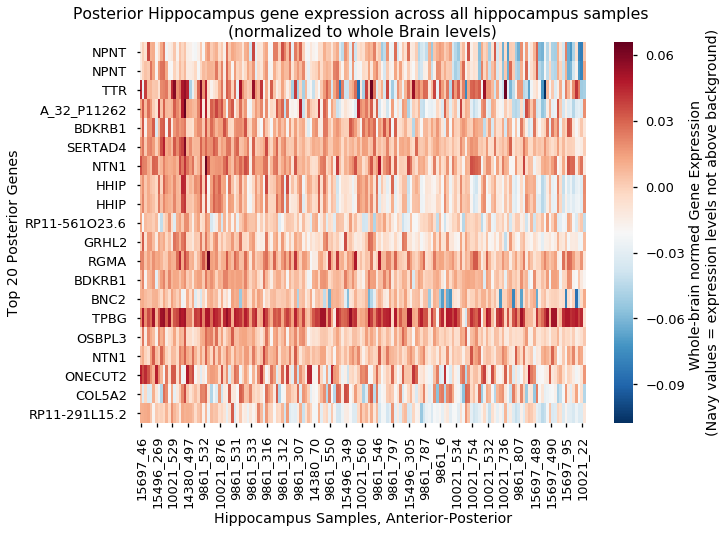

In [37]:
cutdf = pandas.DataFrame(wtd_gxha,copy=True)

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf.loc[cutdf.index.tolist()[::-1],sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']
plotr

plt.close()
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',
            cbar_kws={'label': 'Whole-brain normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Posterior Hippocampus gene expression across all hippocampus samples \n(normalized to whole Brain levels)')
plt.ylabel('Top 20 Posterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

In [51]:
jnk.transform(x.reshape(-1,1))[0][0]

0.50640794555939095

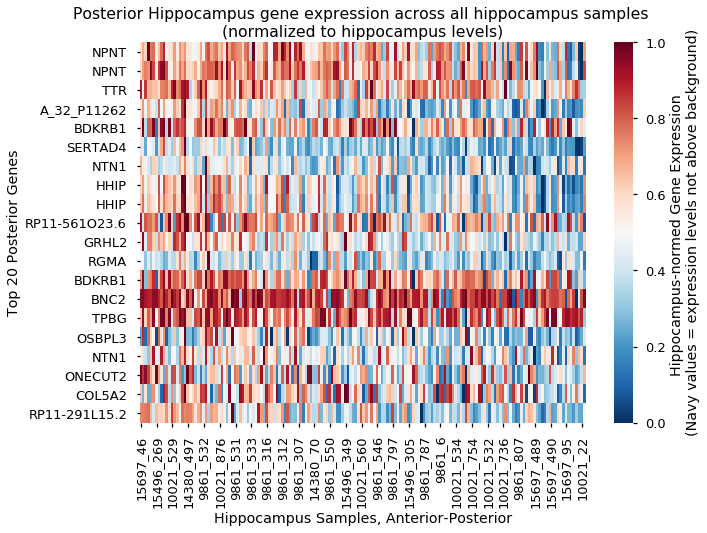

In [52]:
cutdf = pandas.DataFrame(wtd_gxha,copy=True)

mat = np.zeros_like(cutdf.values)
for i in range(cutdf.shape[0]):
    jnk = MinMaxScaler().fit(cutdf.loc[cutdf.index[i]].dropna().values.reshape(-1,1))
    for j,x in enumerate(cutdf.loc[cutdf.index[i]].values):
        if pandas.notnull(x):
            mat[i,j] = jnk.transform(x.reshape(-1,1))[0][0]
cutdf = pandas.DataFrame(mat, index = cutdf.index, columns = cutdf.columns)

sortr = pandas.DataFrame(cutdf,copy=True)
sortr.loc['position'] = df.position_along_hipp_AP_axis.values
sortr = sortr.sort_values('position',axis=1,ascending=False)
plotr = cutdf.loc[cutdf.index.tolist()[::-1],sortr.columns]
plotr.index = probes.loc[plotr.index]['gene_symbol']

plt.close()
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(plotr,cmap='RdBu_r',
            cbar_kws={'label': 'Hippocampus-normed Gene Expression \n(Navy values = expression levels not above background)'})
plt.title('Posterior Hippocampus gene expression across all hippocampus samples \n(normalized to hippocampus levels)')
plt.ylabel('Top 20 Posterior Genes')
plt.xlabel('Hippocampus Samples, Anterior-Posterior')
plt.show()

In [ ]:
print(gene)
plt.close()
sns.regplot(list(range(len(row.values[i,:]))),
            row.values[i,:])
plt.show()

In [187]:
row.shape

(2, 170)

In [192]:
post50 = pandas.read_csv('/Users/jakevogel/Science/AHBA/Post50Gxp_norm.csv',
                        index_col=0)
#for gene in post50.index.unique():
    row = post50.loc[gene]
    if len(row.shape) == 1:
        print(gene)
        plt.close()
        sns.regplot(df.sort_values('position_along_hipp_AP_axis'
                                      )['position_along_hipp_AP_axis'].values,
                    row.values)
        plt.show()
    else:
        for i in range(len(row)):
            print(gene)
            plt.close()
            sns.regplot(df.sort_values('position_along_hipp_AP_axis'
                                      )['position_along_hipp_AP_axis'].values,
                        row.values[i,:])
            plt.show()

IndentationError: unexpected indent (<ipython-input-192-5e8daad76fd4>, line 4)

In [193]:
post50 = pandas.read_csv('/Users/jakevogel/Science/AHBA/Ant50Gxp_norm.csv',
                        index_col=0)
#for gene in post50.index.unique():
    row = post50.loc[gene]
    if len(row.shape) == 1:
        print(gene)
        plt.close()
        sns.regplot(df.sort_values('position_along_hipp_AP_axis'
                                      )['position_along_hipp_AP_axis'].values,
                    row.values)
        plt.show()
    else:
        for i in range(len(row)):
            print(gene)
            plt.close()
            sns.regplot(df.sort_values('position_along_hipp_AP_axis'
                                      )['position_along_hipp_AP_axis'].values,
                        row.values[i,:])
            plt.show()

IndentationError: unexpected indent (<ipython-input-193-65132da09e8a>, line 4)

# RENDER RESULTS

In [132]:
input_coords = []
for i,row in df.iterrows():
    input_coords.append(convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']],'xyz'))
for col in df.columns[-4:]:
    lab = 'hipp_only_%s'%col
    make_expression_image(df[col], input_coords, projection_space = mni, 
                          wdir = wdir, nm = lab, vrad=3)
    print('finished',lab)

finished hipp_only_a20_SPCR_NEW_expression
finished hipp_only_a20_SPCR_NEW_bin_xp
finished hipp_only_p20_SPCR_NEW_expression
finished hipp_only_p20_SPCR_NEW_bin_xp


In [133]:
a20_hipp_xp = ni.load(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_only_a20_SPCR_NEW_expression_xp_image.nii.gz'
                    ).get_data()

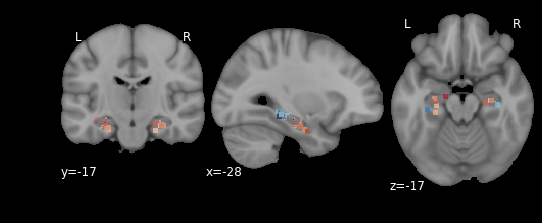

In [136]:
a20_hipp_xp = ni.load(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_only_a20_SPCR_NEW_expression_xp_image.nii.gz'
                    )
p20_hipp_xp = ni.load(
        '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_only_p20_SPCR_NEW_expression_xp_image.nii.gz'
                    )
plt.close()
plotting.plot_roi(p20_hipp_xp, mni, draw_cross=False, cmap='RdBu_r')
plt.show()

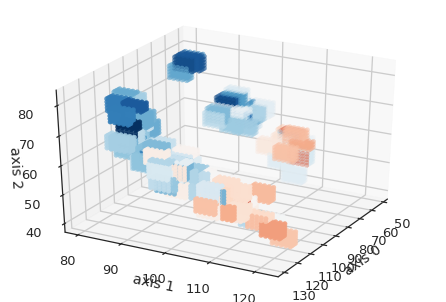

In [137]:
label_locations = np.where(a20_hipp_xp.get_data() != 0)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = a20_hipp_xp.get_data()[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



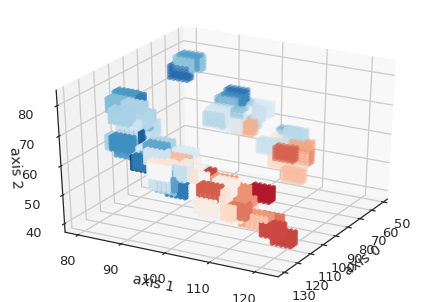

In [139]:
label_locations = np.where(p20_hipp_xp.get_data() != 0)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = p20_hipp_xp.get_data()[label_locations],
          cmap='RdBu_r')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



## Fill in the hippocampus

In [3]:
#jnk = ni.load('/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
jnk = ni.load('/usr/share/fsl/5.0/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
atlas = jnk.get_data()
aff = jnk.affine

In [4]:
hipp = np.zeros_like(atlas)
hipp[(atlas==9) | (atlas==19)] = 1
nhipp = ni.Nifti1Image(hipp, aff)

In [39]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(nhipp, mni, draw_cross=False, cmap='Reds')
plt.show()

NameError: name 'nhipp' is not defined

In [6]:
hipp = nhipp.get_data()
hcoods = np.where(hipp==1)

In [16]:
s_coords = [convert_coords([round(df.mni_nlin_x[x]),
                 round(df.mni_nlin_y[x]), 
                round(df.mni_nlin_z[x])],'xyz') for x in range(df.shape[0])]

In [22]:
vox = pandas.DataFrame(index=range(len(hcoods[0])),columns=['x','y','z','ind'])
for c in range(len(hcoods[0])):
    cord = [hcoods[0][c], hcoods[1][c], hcoods[2][c]]
    dists = [abs(cord[0] - s_coords[x][0]) + \
             abs(cord[1] - s_coords[x][1]) + \
             abs(cord[2] - s_coords[x][2]) for x in range(len(s_coords))]
    vox.loc[c, ['x','y','z']] = cord
    vox.loc[c,'ind'] = np.argmin(dists)
    if c%1000 == 0:
        print('finished',c)

finished 0
finished 1000
finished 2000
finished 3000
finished 4000
finished 5000
finished 6000
finished 7000
finished 8000
finished 9000
finished 10000
finished 11000


In [85]:
vox.to_csv(os.path.join(wdir,'MAIN_vox_mapping.csv'),index=False)

In [17]:
vox = pandas.read_csv(os.path.join(wdir,'MAIN_vox_mapping.csv')).astype(int)

In [62]:
df.columns[-1]

'position_along_hipp_AP_axis'

In [12]:
p_vec = [xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_20'],xp.columns[x]
              ].mean() for x in range(xp.shape[1])]
a_vec = [xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_20'],xp.columns[x]
              ].mean() for x in range(xp.shape[1])]

In [19]:
rend_hipp_p = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_p[row['x'],row['y'],row['z']] = p_vec[row['ind']]

In [20]:
rend_hipp_a = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_a[row['x'],row['y'],row['z']] = a_vec[row['ind']]

In [21]:
mod = pcalr_out_NEW['final_model']
X = pcalr_out_NEW['pca_object'].transform(xp.T)
y = mod.predict(X)


In [22]:
rend_hipp_T = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_T[row['x'],row['y'],row['z']] = y[row['ind']]

In [29]:
max(rend_hipp_a.flat)

1.4992946

In [50]:
fig.colorbar?

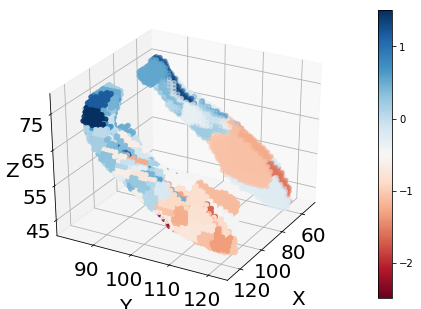

In [49]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
f = ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('\nX',fontsize=20,linespacing=4)
ax.set_xticks(range(120,50,-20))
plt.setp(ax.get_xticklabels(), fontsize=20)
ax.set_ylabel('\nY',fontsize=20, linespacing=2)
ax.set_yticks(range(90,121,10))
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_zlabel('Z',fontsize=20, linespacing=6)
ax.set_zticks(range(45,76,10))
ax.tick_params(labelsize=20)
fig.colorbar(f,ticks=[-2,-1,0,1,2])
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/POST_HippRender.pdf',
#           bbox_inches='tight')

plt.show()


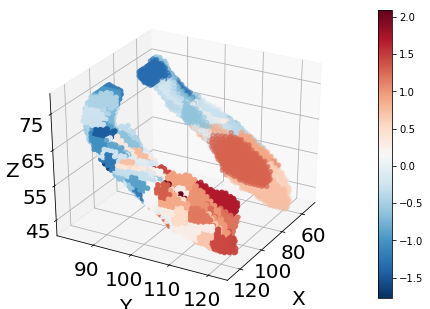

In [44]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
f = ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a[label_locations],
          cmap='RdBu_r')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('\nX',fontsize=20,linespacing=4)
ax.set_xticks(range(120,50,-20))
plt.setp(ax.get_xticklabels(), fontsize=20)
ax.set_ylabel('\nY',fontsize=20, linespacing=2)
ax.set_yticks(range(90,121,10))
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_zlabel('Z',fontsize=20, linespacing=6)
ax.set_zticks(range(45,76,10))
ax.tick_params(labelsize=20)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/ANT_HippRender.pdf',
#           bbox_inches='tight')
fig.colorbar(f)
plt.show()



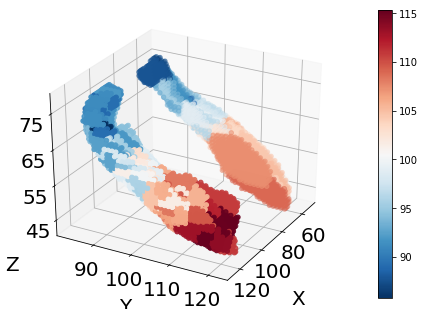

In [46]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
#fig = plt.figure(figsize=(8,6))
fig = plt.figure()
ax = Axes3D(fig)
f = ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_T[label_locations],
          cmap='RdBu_r')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('\nX',fontsize=20,linespacing=4)
ax.set_xticks(range(120,50,-20))
plt.setp(ax.get_xticklabels(), fontsize=20)
ax.set_ylabel('\nY',fontsize=20, linespacing=2)
ax.set_yticks(range(90,121,10))
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_zlabel('\n\nZ',fontsize=20, linespacing=6)
ax.set_zticks(range(45,76,10))
ax.tick_params(labelsize=20)
#ax.dist=11
fig.colorbar(f)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/cbar.pdf',
           bbox_inches='tight')
plt.show()




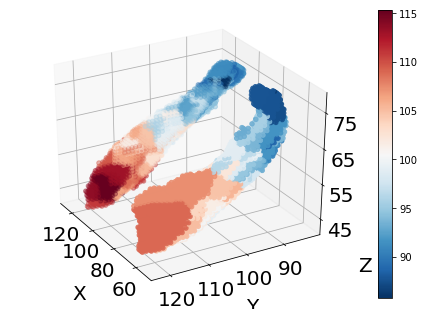

In [42]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
p = ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_T[label_locations],
          cmap='RdBu_r')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 180, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('\nX',fontsize=20,linespacing=3.2)
ax.set_xticks(range(120,50,-20))
plt.setp(ax.get_xticklabels(), fontsize=20)
ax.set_ylabel('\nY',fontsize=20, linespacing=2)
ax.set_yticks(range(90,121,10))
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_zlabel('\n\n\nZ',fontsize=20, linespacing=4)
ax.set_zticks(range(45,76,10))
plt.setp(ax.get_zticklabels(), fontsize=20)
ax.tick_params(labelsize=20)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/HippRenderL.pdf',
#           bbox_inches='tight')
#ax.dist=11
fig.colorbar(p)
plt.show()





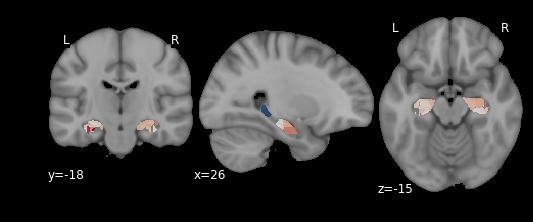

In [32]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ni.Nifti1Image(rend_hipp_a, aff), mni, draw_cross=False, cmap='RdBu')
plt.show()

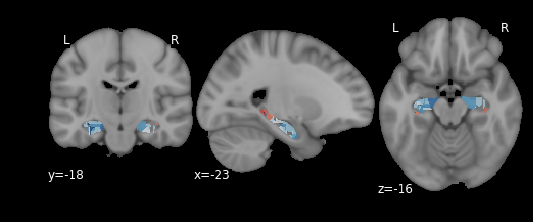

In [33]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ni.Nifti1Image(rend_hipp_p, aff), mni, draw_cross=False, cmap='RdBu')
plt.show()

In [115]:
for y in coord:
    print([y + x for x in range(-1,2)])

[51, 52, 53]
[100, 101, 102]
[59, 60, 61]


In [107]:
len(make_cube(cord,radius=2)[0])

27

In [81]:
for c in range(len(hcoods[0])):
    cord = [hcoods[0][c], hcoods[1][c], hcoods[2][c]]
    if any(hipp[make_cube(cord,2)]==0):
        vox.loc[c,'surface'] = 1
    else:
        vox.loc[c,'surface'] = 0
    if c%1000 == 0:
        print('finished',c)

finished 0
finished 1000
finished 2000
finished 3000
finished 4000
finished 5000
finished 6000
finished 7000
finished 8000
finished 9000
finished 10000
finished 11000


In [505]:
surf_vox = pandas.DataFrame(vox[vox.surface==1],copy=True)

In [40]:
len(sample_surf_ind)

3702

In [42]:
df.columns

Index(['Unnamed: 0', 'donor', 'sample', 'structure_id', 'slab_num', 'well_id',
       'slab_type', 'structure_acronym', 'structure_name', 'polygon_id',
       'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z',
       'gabe_label', 'mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z',
       'position_along_hipp_AP_axis'],
      dtype='object')

In [506]:
sample_surf_ind = []
arr = surf_vox[['x','y','z']].values
for i,row in df.iterrows():
    cord = convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz')
    dists = [abs(cord[0] - arr[x,0]) + \
             abs(cord[1] -  arr[x,1]) + \
             abs(cord[2] -  arr[x,2]) for x in range(surf_vox.shape[0])]
    sample_surf_ind.append(np.argmin(dists))
    if i%10 == 0:
        print('finished',i)

finished 0
finished 10
finished 20
finished 30
finished 40
finished 50
finished 60
finished 70
finished 80
finished 90
finished 100
finished 110
finished 120
finished 130
finished 140
finished 150
finished 160


In [510]:
vox.loc[sample_surf_ind[0]]

x           61
y          113
z           46
ind         30
surface      1
Name: 2141, dtype: int64

In [44]:
len(sample_surf_ind)

170

In [511]:
df.loc[:,'surface_coordinate_index'] = sample_surf_ind

In [208]:
sample_surf_ind = []
arr = surf_vox[['x','y','z']].values
for i,row in gdf.iterrows():
    cord = convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz')
    dists = [abs(cord[0] - arr[x,0]) + \
             abs(cord[1] -  arr[x,1]) + \
             abs(cord[2] -  arr[x,2]) for x in range(surf_vox.shape[0])]
    sample_surf_ind.append(np.argmin(dists))
    if i%100 == 0:
        print('finished',i)
gdf.loc[:,'surface_coordinate_index'] = sample_surf_ind

finished 0
finished 100
finished 200
finished 300
finished 400
finished 500
finished 600
finished 700
finished 800
finished 900
finished 1000
finished 1100
finished 1200
finished 1300
finished 1400
finished 1500
finished 1600
finished 1700
finished 1800
finished 1900
finished 2000
finished 2100
finished 2200
finished 2300
finished 2400
finished 2500
finished 2600
finished 2700
finished 2800
finished 2900
finished 3000
finished 3100
finished 3200
finished 3300
finished 3400
finished 3500
finished 3600
finished 3700


In [224]:
for i,col in enumerate(xp.columns):
    df.loc[i,'HAGS_Index_r'] = stats.pearsonr(xp[col].values,np.array(pcalr_out_NEW['betas']))[0]
    df.loc[i,'HAGS_Index_dot'] = np.dot(xp[col].values,np.array(pcalr_out_NEW['betas']))

In [239]:
surf_vox.shape

(6250, 5)

In [237]:
for i,row in gdf.iterrows():
    idx = row['surface_coordinate_index']
    gdf.loc[i,'HAGS_of_closest_Hipp_coordinate'] = df.loc[vox.loc[idx]['ind']]['HAGS_Index_r']

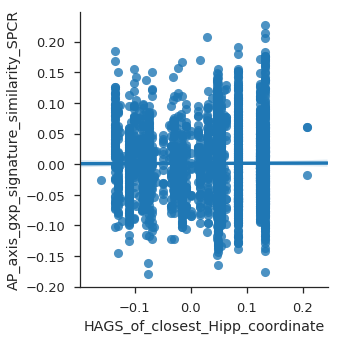

In [230]:
plt.close()
sns.lmplot(x = 'HAGS_of_closest_Hipp_coordinate',
           y = 'AP_axis_gxp_signature_similarity_SPCR',
           data = gdf)
plt.show()

In [48]:
surf_vox = surf_vox.astype(int)

In [49]:
rend_hipp_p2 = np.zeros_like(hipp)
for i,row in surf_vox.iloc[sample_surf_ind].iterrows():
    rend_hipp_p2[row['x'],row['y'],row['z']] = p_vec[row['ind']]

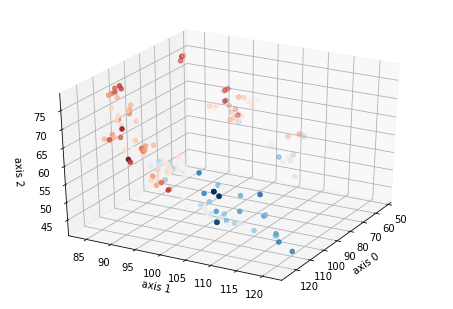

In [50]:
plt.close()
label_locations = [surf_vox.iloc[sample_surf_ind]['x'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['y'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['z'].tolist()]
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p2[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



In [51]:
rend_hipp_a2 = np.zeros_like(hipp)
for i,row in surf_vox.iloc[sample_surf_ind].iterrows():
    rend_hipp_a2[row['x'],row['y'],row['z']] = a_vec[row['ind']]

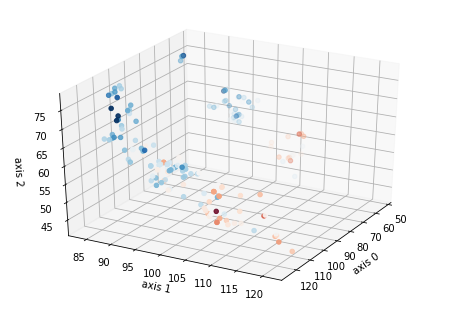

In [52]:
plt.close()
label_locations = [surf_vox.iloc[sample_surf_ind]['x'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['y'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['z'].tolist()]
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a2[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



In [56]:
rend_hipp_p2[rend_hipp_p2>0].shape

(63,)

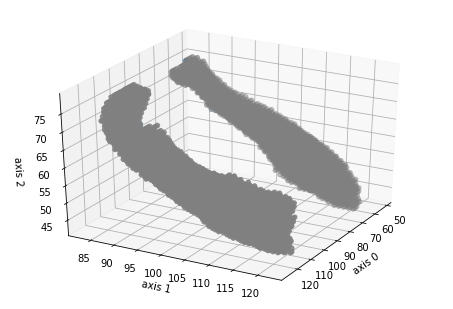

In [59]:
plt.close()
label_locations = [surf_vox.iloc[sample_surf_ind]['x'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['y'].tolist(),
                   surf_vox.iloc[sample_surf_ind]['z'].tolist()]
hipp_labels = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(hipp_labels[0], hipp_labels[1], hipp_labels[2], c = 'gray')
#ax2 = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a2[label_locations],
          cmap='RdBu')
#To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()



In [60]:
surf_vox.shape

(6250, 6)

In [513]:
from copy import deepcopy

In [514]:
s_coords = deepcopy(label_locations)
for i,row in surf_vox.iterrows():
    cord = [row['x'],row['y'],row['z']]
    dists = [abs(cord[0] - s_coords[0][x]) + \
             abs(cord[1] - s_coords[1][x]) + \
             abs(cord[2] - s_coords[2][x]) for x in range(len(s_coords[0]))]
    surf_vox.loc[i,'closest_surface_ind'] = np.argmin(dists)
    if i%1000 == 0:
        print('finished',i)

finished 0
finished 2000
finished 3000
finished 4000
finished 6000
finished 7000
finished 8000
finished 9000
finished 11000


In [72]:
surf_vox.columns

Index(['x', 'y', 'z', 'ind', 'surface', 'closest_surface_ind'], dtype='object')

In [90]:
rend_hipp_p3 = np.zeros_like(hipp)
for i,row in surf_vox.iterrows():
    rend_hipp_p3[row['x'],row['y'],row['z']] = p_vec[row['ind']]

In [91]:
rend_hipp_a3 = np.zeros_like(hipp)
for i,row in surf_vox.iterrows():
    rend_hipp_a3[row['x'],row['y'],row['z']] = a_vec[row['ind']]

In [83]:
len(label_locations[0])

170

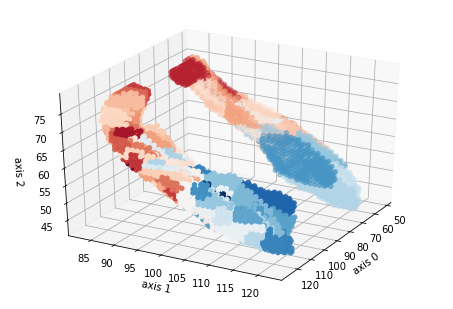

In [87]:
plt.close()
label_locations = [surf_vox['x'].tolist(),
                   surf_vox['y'].tolist(),
                   surf_vox['z'].tolist()]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p3[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


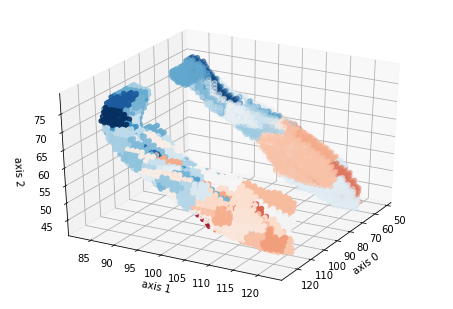

In [92]:
plt.close()
label_locations = [surf_vox['x'].tolist(),
                   surf_vox['y'].tolist(),
                   surf_vox['z'].tolist()]
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_a3[label_locations],
          cmap='RdBu')
# To split into LR, we need to visualize where the LR split is, where front is
for angle in range(0, 30):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()


In [76]:
import plotly

In [77]:
temp_trace = plotly.graph_objs.Scatter3d(x = surf_vox['x'].tolist(),
                                        y = surf_vox['y'].tolist(),
                                        z = surf_vox['z'].tolist(),
                                        name = 'hipp',
                                        mode = 'markers',
                                        marker = {'size': 2, 
                                                  'color': rend_hipp_a3[label_locations].tolist(), 
                                                  'colorscale':'RdBu'}
                                        )


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='test.html')


NameError: name 'surf_vox' is not defined

In [103]:
rend_hipp_p[rend_hipp_p!=0].shape

(11263,)

In [101]:
label_locations = np.where(hipp == 1)
#label_locations1 = np.where(ap_axis.get_data() > 0)
fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = rend_hipp_p[label_locations],
#           cmap='RdBu')
# # To split into LR, we need to visualize where the LR split is, where front is
# for angle in range(0, 30):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

# ax.set_xlabel('axis 0')
# ax.set_ylabel('axis 1')
# ax.set_zlabel('axis 2')
# plt.show()


In [104]:
temp_trace = plotly.graph_objs.Scatter3d(x = label_locations[0],
                                        y =  label_locations[1],
                                        z =  label_locations[2],
                                        name = 'hipp',
                                        mode = 'markers',
                                        marker = {'size': 2, 
                                                  'color': rend_hipp_a[label_locations].tolist(), 
                                                  'colorscale':'RdBu'}
                                        )


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='test.html')


'file:///home/users/jvogel/git/hack_projects/test.html'

In [80]:
temp_trace = plotly.graph_objs.Scatter3d(x = label_locations[0],
                                        y =  label_locations[1],
                                        z =  label_locations[2],
                                        name = 'hipp',
                                        mode = 'markers',
                                        marker = {'size': 5, 
                                                  'color': rend_hipp_T[label_locations].tolist(), 
                                                  'colorscale':'RdBu'}
                                        )


layout = plotly.graph_objs.Layout(margin = dict(l=0,r=0,b=0,t=0))

fig = plotly.graph_objs.Figure(data=[temp_trace], layout=layout)
plotly.offline.plot(fig, filename='HIPP_model_results.html')



'file:///Users/jakevogel/git/hack_projects/HIPP_model_results.html'

In [110]:
xp.shape

(58692, 170)

In [111]:
gdf.structure_name.unique()

array(['claustrum, left', 'nucleus accumbens, left',
       'nucleus accumbens, right', 'substantia innominata, right',
       'claustrum, right', 'globus pallidus, external segment, right',
       'lateral nucleus, right',
       'amygdalohippocampal transition zone, right',
       'basolateral nucleus, right', 'basomedial nucleus, right',
       'substantia innominata, left', 'septal nuclei, left',
       'septal nuclei, right', 'globus pallidus, external segment, left',
       'CA1 field, right', 'CA2 field, right', 'CA3 field, right',
       'CA4 field, right', 'dentate gyrus, right',
       'body of caudate nucleus, right', 'subiculum, left',
       'CA1 field, left', 'CA2 field, left', 'CA3 field, left',
       'CA4 field, left', 'dentate gyrus, left',
       'body of caudate nucleus, left', 'putamen, right',
       'inferior frontal gyrus, opercular part, right',
       'posterior orbital gyrus, right',
       'temporal pole, right, superior aspect',
       'precentral gyrus, le

In [250]:
df.gabe_label.value_counts()

H0351.2001    60
H0351.2002    44
H0351.1016    20
H0351.1012    19
H0351.1009    14
H0351.1015    13
Name: gabe_label, dtype: int64

In [251]:
104/170

0.611764705882353

# The triumphant return of Alex

In [95]:
linear_model.LinearRegression?

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


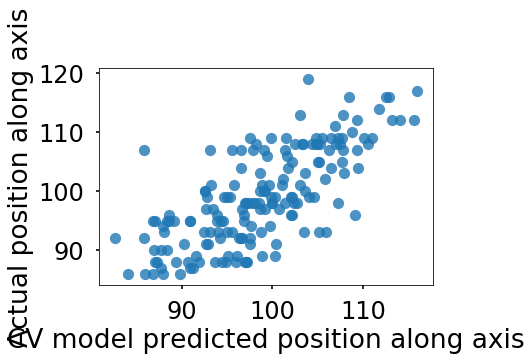

model cv score: r2 =  0.543823424188
running final model
final model fit r2 =  0.688029812944


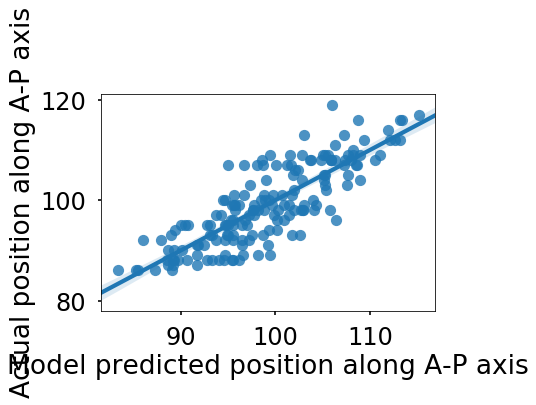

running sanity_check


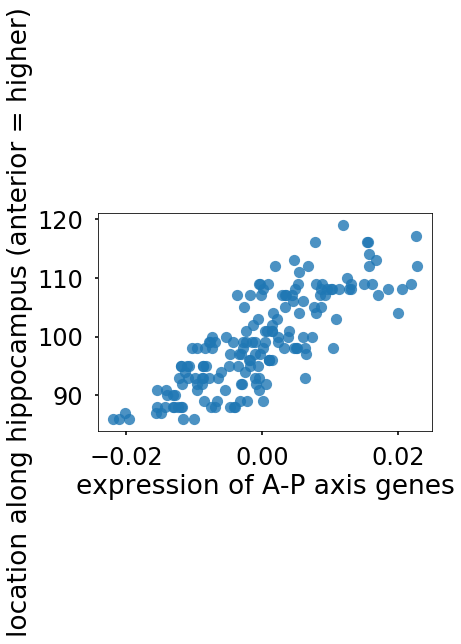

posterior and anterior 100 genes vs. y:  r2 = 0.655646897276, p = 9.71199641258e-41 




In [108]:
# testing weighted averages
pcr_out = PCA_LR_pipeline(xp.values.T,
                            (df.position_along_hipp_AP_axis), 
                          clf = linear_model.LinearRegression(),
                          pca=PCA(n_components=20),
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

In [112]:
sum(jnk.explained_variance_ratio_)

0.72623665158755746

In [117]:
jnk = pcalr_out_NEW2['final_model']

In [120]:
from math import isclose

In [127]:
len([x for x in jnk.coef_ if not isclose(x,0,rel_tol=1e-10)])

55

In [129]:
#jnk.coef_

In [921]:
from sklearn.cross_decomposition import PLSRegression

In [134]:
mod = PLSRegression(n_components=50).fit(xp.values.T, df.position_along_hipp_AP_axis)


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 43
  warnings.warn('Y residual constant at iteration %s' % k)


In [147]:
#mod.predict(xp.values.T).reshape(170)
mod.predict(xp.values.T)[:,0]

array([  86.        ,   86.        ,   86.        ,   85.99999999,
         85.99999999,  109.        ,  108.99999999,  107.        ,
        110.        ,  111.        ,   92.        ,   92.        ,
         93.        ,   92.99999999,   93.        ,   96.        ,
         94.        ,   95.00000001,   94.        ,   95.        ,
         96.        ,   98.        ,   98.00000001,   98.        ,
        107.00000002,  107.        ,  107.00000001,  107.        ,
        107.        ,  105.99999999,  108.99999999,   93.        ,
         91.00000001,   93.        ,   91.00000001,   89.        ,
         91.        ,   91.        ,   91.        ,  106.99999998,
        109.        ,  107.99999999,  109.00000002,  108.        ,
         88.        ,   88.00000002,   88.99999999,  104.00000001,
        103.        ,  104.        ,   87.99999999,   88.        ,
         89.        ,  116.        ,  116.        ,  116.00000001,
        103.        ,  104.99999999,  100.        ,   98.99999

performing model cross-validation
using basic 10-fold cross-validation


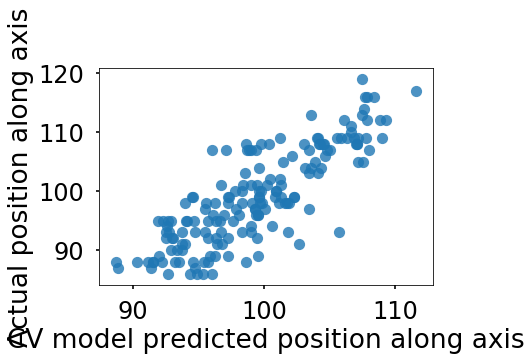

model cv score: r2 =  0.685768151409
running final model
final model fit r2 =  0.999989743405


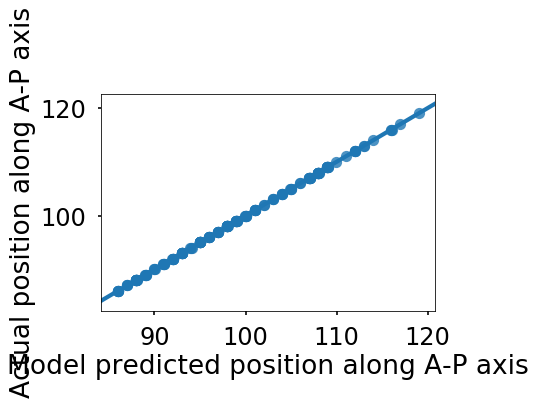

running sanity_check


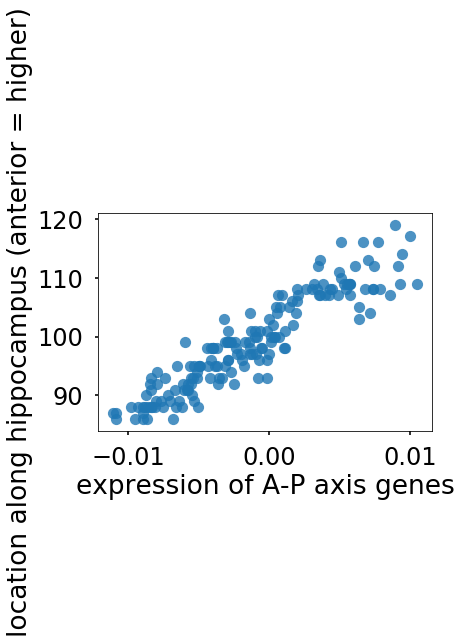

posterior and anterior 100 genes vs. y:  r2 = 0.860655622862, p = 8.40089362298e-74 




In [183]:
# testing weighted averages
pls_out = PCA_LR_pipeline(xp.values.T,
                            (df.position_along_hipp_AP_axis), 
                          clf = PLSRegression(n_components=20),
                          pca=None,
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

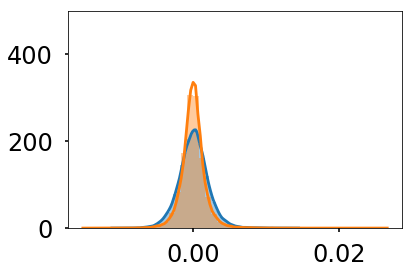

In [158]:
plt.close()
sns.distplot(pls_out['betas'])
sns.distplot(pcalr_out_NEW2['betas'])
plt.ylim(0,500)
plt.show()

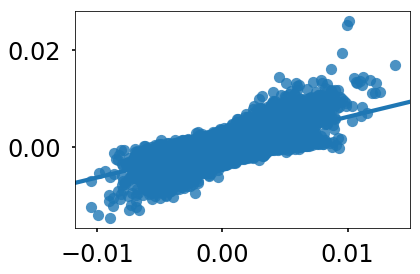

In [159]:
plt.close()
sns.regplot(pls_out['betas'], pcalr_out_NEW2['betas'])
plt.show()

In [160]:
jnk = pandas.DataFrame(index = range(len(pls_out['betas'])), columns = ['pls','lpcr'])
jnk.loc[:,'pls'] = pls_out['betas']
jnk.loc[:,'lpcr'] =  pcalr_out_NEW2['betas']
jnk.loc[:,'gene'] = probes.loc[:,'gene_symbol'].values

In [186]:
jnk.sort_values('pls',ascending=False).head(20)

pls      lpcr          gene
23274  0.013777  0.016976         RSPH9
40112  0.012621  0.011282         NR2F2
2781   0.012260  0.013176         KCNG1
40987  0.012194  0.011192         NR2F2
35503  0.011922  0.011182         NR2F2
14245  0.011755  0.013917         SYTL2
35268  0.011522  0.006943         CADM1
20529  0.011215  0.014526         LYPD1
35836  0.011177  0.008229        OBFC2A
51984  0.011109  0.012813  A_23_P213527
41473  0.011081  0.006512         CADM1
14246  0.010993  0.013667         SYTL2
14244  0.010729  0.013277         SYTL2
6189   0.010655  0.013477         SSTR1
24685  0.010508  0.014255         PYDC1
26853  0.010331  0.005474          GHSR
51675  0.010326  0.008463  A_24_P331711
4418   0.010085  0.026119      SERPINF1
4417   0.009986  0.025298      SERPINF1
39663  0.009905  0.008458          GLI1

In [174]:
fit_mod = pcalr_out_NEW2['final_model']
pred = fit_mod.predict(pcalr_out_NEW2['pca_object'].transform(xp.values.T))
resid = pred - df.position_along_hipp_AP_axis.values

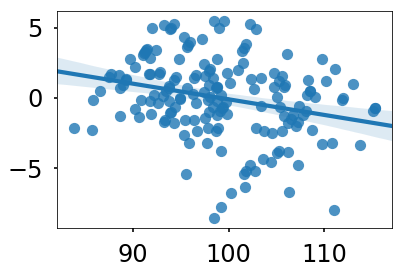

In [175]:
plt.close()
sns.regplot(pred, resid)
plt.show()

In [181]:
fit_mod = pls_out['final_model']
pred = fit_mod.predict(xp.values.T)[:,0]
resid = pred - df.position_along_hipp_AP_axis.values

In [180]:
len(resid)

170

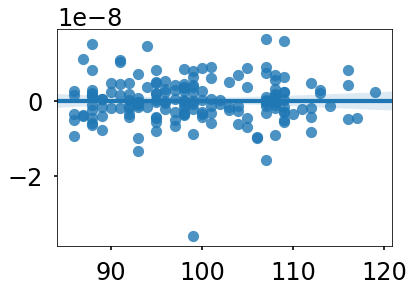

In [182]:
plt.close()
sns.regplot(pred, resid)
plt.show()

In [923]:
pca_tfm.shape

(170, 170)

In [929]:
import sys
sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
import CrossDecomp as pls

In [947]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
ncs = 20
nc_chooser = pandas.DataFrame(index = range(ncs), columns = ['nc','r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    pred = cross_val_predict(PLSRegression(n_components=k+1), xp.T, 
                             df.position_along_hipp_AP_axis, 
                            groups = df.structure_acronym, cv=10)
    nc_chooser.loc[i, 'r2'] = r2_score(y_true=df.position_along_hipp_AP_axis, y_pred=pred)
    nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=df.position_along_hipp_AP_axis, y_pred=pred)
    nc_chooser.loc[i, 'estimator'] = lab
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


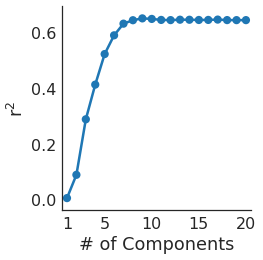

In [1006]:
sns.set_context('paper', font_scale=2)
nc_chooser.loc[:,'nc'] = range(1,21)
plt.close()
g = sns.factorplot(x='nc', y='r2', data=nc_chooser, aspect=1)
g.set_xticklabels(['' if x not in [1,5,10,15,20] else x for x in range(1,21)])
plt.xlabel('# of Components')
plt.ylabel('r$^2$')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/PLS_CV.pdf', 
            bbox_inches='tight')
plt.show()


finished iteration 0
finished iteration 10
finished iteration 20
finished iteration 30
finished iteration 40
finished iteration 50
finished iteration 60
finished iteration 70
finished iteration 80
finished iteration 90


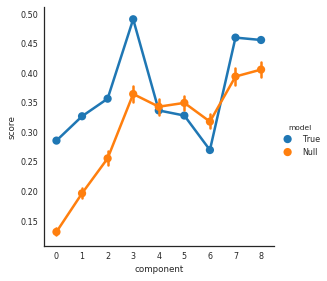

component 0: p = 0.01  ***
component 1: p = 0.02  ***
component 2: p = 0.05  ***
component 3: p = 0.06
component 4: p = 0.51
component 5: p = 0.65
component 6: p = 0.78
component 7: p = 0.2
component 8: p = 0.27


In [1012]:
jnk = pls.evaluate_components(PLSRegression(n_components=9), xp.T,  df.position_along_hipp_AP_axis, 
                              n_iterations=100, check=10)

In [1016]:
clf = PLSRegression(n_components=9)
cv=10
cv_strategy=10
y = df.position_along_hipp_AP_axis
score = []
preds = np.zeros((cv_strategy,len(y)))
for i in range(cv_strategy):
    sel = model_selection.KFold(n_splits=cv, shuffle=True)
    predicted = model_selection.cross_val_predict(clf, xp.T, y=y, cv=sel)
    preds[i,:] = predicted[:,0]
    score.append(stats.pearsonr(predicted[:,0], y)[0]**2)
    print('completed iteration',i+1)
score


completed iteration 1
completed iteration 2
completed iteration 3
completed iteration 4
completed iteration 5
completed iteration 6
completed iteration 7
completed iteration 8
completed iteration 9
completed iteration 10


[0.72330624879038807,
 0.75589543929583103,
 0.75213202747701757,
 0.75207999653861468,
 0.75045163352351929,
 0.75253282291252688,
 0.72751655788284075,
 0.74355806289586279,
 0.7533459649039187,
 0.74219444856188121]

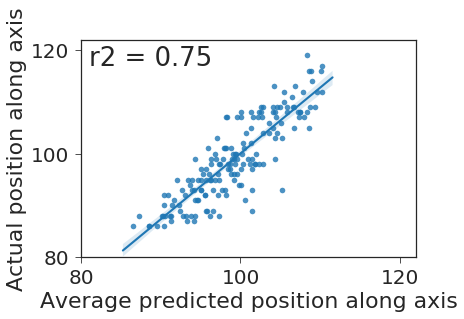

In [1018]:
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.set_style('ticks')
sns.regplot(preds.mean(0), y, fit_reg=True)
plt.xlim(80,122)
plt.ylim(80,122)
plt.xticks(range(80,121,20))
plt.yticks(range(80,121,20))
plt.xlabel('Average predicted position along axis')
plt.ylabel('Actual position along axis')
r2 = np.float16(stats.pearsonr(preds.mean(0), y)[0]**2)
plt.text(81, 117,'r2 = %s'%(float('%.2g' % r2)), fontsize=26)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/PLS_model.pdf', 
            bbox_inches='tight')
plt.show()


performing model cross-validation
using basic 10-fold cross-validation


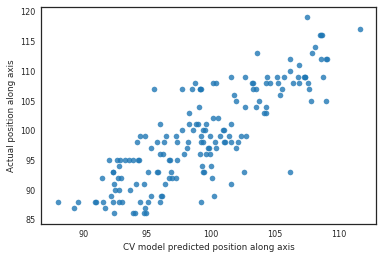

model cv score: r2 =  0.68539415208
running final model
final model fit r2 =  0.984837291294


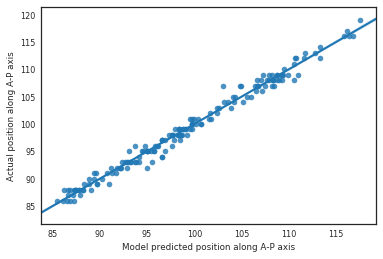

running sanity_check


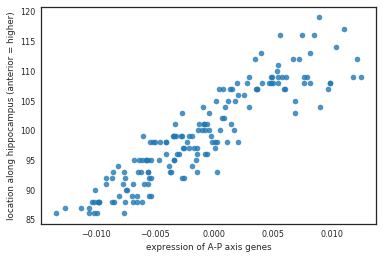

posterior and anterior 100 genes vs. y:  r2 = 0.837916377719, p = 2.78376946536e-68 




In [952]:
# testing weighted averages
pls_out2 = PCA_LR_pipeline(xp.values.T,
                            (df.position_along_hipp_AP_axis), 
                          clf = PLSRegression(n_components=9),
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [100], pca=None,
                               sanity_check_style = 'model')

In [956]:
pls_mod = PLSRegression(n_components=9).fit(xp.T, df.position_along_hipp_AP_axis)

In [984]:
pls_beta = pandas.concat([pandas.Series(pls_mod.coef_[:,0]), probes.gene_symbol], axis=1)
pls_beta.sort_values(0,ascending=False)
pls_t50 = pls_beta.sort_values(0,ascending=False).head(50).index.tolist()
pls_b50 = pls_beta.sort_values(0,ascending=False).head(50).index.tolist()
pls_top100 = pls_t50 + pls_b50
print('n in gene set 1', len([x for x in pls_top100 if x in top_100.index]))
print('n in gene set 1 + 2', len([x for x in pls_top100 if x in top_600.index]))
print('n in gene set 1 + 2 + 3', len([x for x in pls_top100 if x in top_2700.index]))

n in gene set 1 50
n in gene set 1 + 2 92
n in gene set 1 + 2 + 3 100


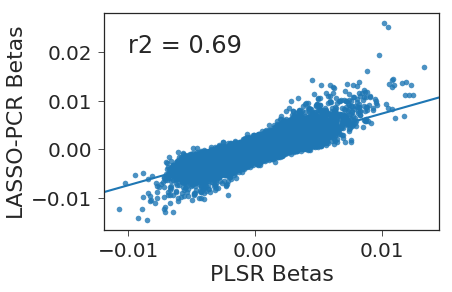

In [1028]:
plt.close()
sns.regplot(pls_mod.coef_[:,0], pcalr_out_NEW2['betas'])
plt.ylabel('LASSO-PCR Betas')
plt.xlabel('PLSR Betas')
r2 = stats.pearsonr(pls_mod.coef_[:,0], pcalr_out_NEW2['betas'])[0]**2
plt.text(-0.01, 0.02,'r2 = %s'%(float('%.2g' % r2)), fontsize=24)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/PLS_comp.pdf', bbox_inches='tight')
plt.show()

In [977]:
pls_beta

range(0, 58692)

In [995]:
pls_beta = pls_beta.sort_values(0,ascending=False)
pls_beta.loc[:,'pls_rank'] = range(len(pls_beta))
pls_beta = pls_beta.sort_values(0,ascending=True)
pls_beta.loc[:,'inv_pls_rank'] = range(len(pls_beta))

In [1035]:
pls_beta.columns = ['beta'] + pls_beta.columns[1:].tolist()
pls_beta.loc[pls_top100,['beta','gene_symbol']
            ].to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Table_S4_PLS.csv')

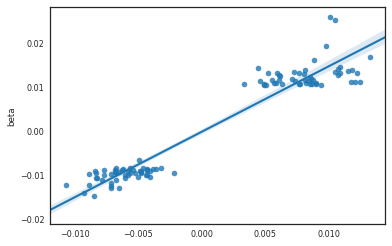

(0.96097636272014131, 4.65653281466728e-57)

In [993]:
plt.close()
sns.regplot(pls_beta.loc[top_100.index][0].values,
               betas.loc[top_100.index]['beta'])
plt.show()
stats.pearsonr(pls_beta.loc[top_100.index][0].values,
               betas.loc[top_100.index]['beta'])

# MAE stuff

In [1135]:
from sklearn.metrics import mean_absolute_error
for col in df.columns[-6:]:
    mae = mean_absolute_error(y_pred=df[col].values, y_true=df.position_along_hipp_AP_axis.values)
    print('%s: %s'%(col,mae))

All 58k: 2.17167002428
Set 1: 1.83934160541
Set 2: 2.38603721566
Set 1,2: 2.2042331308
Set 3: 1.85440130548
Set 1,2,3: 1.46009297804
